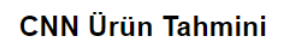

# Versions

# About Data Set

Amazon'da satışı yapılan ev ürünlerinin tahminlemesi yapılan bu data setinde 4 sınıfa ait 4196 resim bulunmaktadır. ('Area Rugs', 'Coffee Cups & Mugs', 'Paints', 'Yarn') 3355 resime train datasetinde ve 841 resim test datasetinde yer almaktadır. 


Test datasinda classlar yok, bu data sadece final predict alinip, submission asamasinda kullanilacak. 
Bu egitim ve test islemleri train datasi uzerinden  gerceklestirilecek.



**YOL HARITASI:**
**1)**  **Resim kalitesi iyi ise**  Manuel CNN yaparken Image Generation'da olabildigince fazla secenek uygula ki model daha iyi ogrensin (Cunku Manuel CNN'in onceden ogrenilmis agirliklari yok). **Resim kalitesi iyi degilse bunu yapmamak daha iyi olabilir, dene ve gor.**

**2)** Transfer Learning (TL) modeller kullanirken Image Generation'daki secenekleri azaltabilirsin, zaten hazir agirliklar var, bosa modeli yavaslatma.

**3)** Image Generation'u sadece train datasina uyguladim, teste uygulamadim. **Bu NB deki mimari yapi bunu gerektiriyor. Ama istersek test datasina da Img Gen uygulamak mumkun.**

**4)** **"Modelin disinda rescaling yapma!"**, **cunku bazi Transfer Learning modelleri bunu default olarak yapiyor.**

**5)** Kullanacagin TL modelinin ozelliklerine **buradan https://keras.io/api/applications/** bak, eger "**include_preprocessing=True**" varsa rescaling icsel (default) olarak yapiliyordur, bir sey yapmana gerek yok. 

**EfficientNetV2B0 - EfficientNetV2BL** ile **ConvNeXtTiny-ConvNeXtXLarge** grubu kismi bu sekilde. **Bu yontemleri kullanirken "model disinda rescaling yapma!"** 

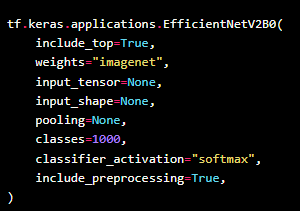

**include_preprocessing=True**" var, **rescaling yapma, verilerin orijinal halleriyle analize devam et.** 

***********************************************

**6)** **"include_preprocessing=True"** satiri yoksa  **tf.keras.applications.xception.preprocess_input** kismini kullanarak modele preprocessing (**rescaling**)islemini kendin ekle. 

Kendimiz bu (tf.keras.applications.xception.preprocess_input) kodu ekleyerek yapmaliyiz. Bunu yaparken **xception** yerine https://keras.io/api/applications/ kismindan bakarak, kullancagin modelin adini yaz. 


**Manuel CNN, Xception, VGG, Resnet, Inception, MobilNet, DenseNet, NasNet ve EfficietNetB0-B7'lerde rescaling icsel (modelin icinde, embed) olarak yapilmiyor.** 

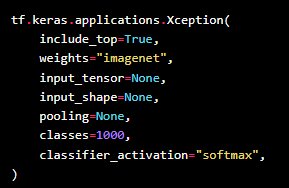

Cunku **"include_preprocessing=True"** satiri yok. **KENDIMIZ EKLEYECEGIZ** 

*****************************

**7)** Calistiracagin modeli once buyuk bir Learning Rate (LR=0.1 gibi) ve kucuk bir Epoch (5-10) ile calistir, skorlara bak. Sonra (**ikinci adim olarak**) sadece model fit kisminda LR yi az kucult (0.01 gibi), Epoch = 5-10 ile bir daha egit. Model bu ara basamaklardaki agirliklari aklinda tutuyor.  

**8)** Sonra **Fine-Tuning = Ince Ayar** kapsaminda; 

   **a)** LR=0.00001 yap, 
    
   **b)** Trainable =True 
    
   **c)** Epoch = 100 ile final sonucu al. 
    
**Bu yontem zaman kazandirir, skorlar da iyilesebilir.**


Yararlandigim NB'ler:

https://www.kaggle.com/code/ahmetcanertekn/flowers-cnn-accuracy-95


https://www.kaggle.com/code/merturper/flowers-cnn-and-transfer-learning-models

Bu calismanin kisa versiyonunun Streamlit ile deploy edilmis hali: https://flowers-data-cnn-and-transfer-learning-models-project.streamlit.app/

*************************************************************************

**Bu calismada asagidaki modelleri kullanildi;**

**1)** Manuel CNN 

**2)** XCeption

**3)** VGG16 (2014)

**4)** Resnet152 (2015) 

**5)** InceptionV3 (2014)

**6)** MobilNet

**7)** DenseNet

**8)** NasNetMobile

**9)** EfficientNetV2B2 

**10)** ConvNeXtTiny (2023)

Modeller hakkinda daha faza bilgi icin: 
https://medium.com/analytics-vidhya/timeline-of-transfer-learning-models-db2a0be39b37

https://towardsdatascience.com/top-10-pre-trained-models-for-image-embedding-every-data-scientist-should-know-88da0ef541cd


## Import the Libraries

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.io import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re
import shutil

#pd.set_option('display.max_columns', None)
# veri çerçevelerindeki tüm sütunların görüntülenmesini istemiyorsanız, display.max_columns seçeneğini None olarak ayarlar.


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [3]:
df = pd.read_csv("Top_Seller_in_Canada.csv", low_memory=False)
df.head(2)

,Reviews: Review Count - 30 days drop %,Reviews: Rating,Reviews: Review Count,Reviews: Review Count - 30 days avg.,Reviews: Review Count - 90 days avg.,Reviews: Review Count - 180 days avg.,Reviews: Review Count - 1 day drop %,Reviews: Review Count - 7 days drop %,Reviews: Review Count - 90 days drop %,Reviews: Reviews - Format Specific,Reviews: Ratings - Format Specific,New Offer Count: 30 days drop %,Locale,Image,Title,Sales Rank: Current,Sales Rank: 30 days avg.,Sales Rank: 90 days avg.,Sales Rank: 180 days avg.,Sales Rank: 1 day drop %,Sales Rank: 7 days drop %,Sales Rank: 30 days drop %,Sales Rank: 90 days drop %,Sales Rank: Lowest,Sales Rank: Highest,Sales Rank: Drops last 30 days,Sales Rank: Drops last 90 days,Sales Rank: Drops last 180 days,Sales Rank: Reference,Sales Rank: Subcategory Sales Ranks,Bought in past month,Last Price Change,Last Update,Last Offer Update,Buy Box: Current,Buy Box: 30 days avg.,Buy Box: 90 days avg.,Buy Box: 180 days avg.,Buy Box: 1 day drop %,Buy Box: 7 days drop %,Buy Box: 30 days drop %,Buy Box: 90 days drop %,Buy Box: Lowest,Buy Box: Highest,Buy Box: Stock,Buy Box out of stock percentage: 90 days OOS %,Buy Box Seller,Buy Box: Is FBA,Buy Box: Unqualified,Buy Box: Preorder,Buy Box: Backorder,Buy Box: Prime Exclusive,Amazon: Current,Amazon: 30 days avg.,Amazon: 90 days avg.,Amazon: 180 days avg.,Amazon: 1 day drop %,Amazon: 7 days drop %,Amazon: 30 days drop %,Amazon: 90 days drop %,Amazon: Lowest,Amazon: Highest,Amazon: Stock,Amazon out of stock percentage: 90 days OOS %,Amazon: Availability of the Amazon offer,Amazon: Amazon offer shipping delay,New: Current,New: 30 days avg.,New: 90 days avg.,New: 180 days avg.,New: 1 day drop %,New: 7 days drop %,New: 30 days drop %,New: 90 days drop %,New: Lowest,New: Highest,New out of stock percentage: 90 days OOS %,MAP restriction,"New, 3rd Party FBA: Current","New, 3rd Party FBA: 30 days avg.","New, 3rd Party FBA: 90 days avg.","New, 3rd Party FBA: 180 days avg.","New, 3rd Party FBA: 1 day drop %","New, 3rd Party FBA: 7 days drop %","New, 3rd Party FBA: 30 days drop %","New, 3rd Party FBA: 90 days drop %","New, 3rd Party FBA: Lowest","New, 3rd Party FBA: Highest",Lowest FBA Seller,FBA Fees:,Referral Fee %,Referral Fee based on current Buy Box price,"New, 3rd Party FBM: Current","New, 3rd Party FBM: 30 days avg.","New, 3rd Party FBM: 90 days avg.","New, 3rd Party FBM: 180 days avg.","New, 3rd Party FBM: 1 day drop %","New, 3rd Party FBM: 7 days drop %","New, 3rd Party FBM: 30 days drop %","New, 3rd Party FBM: 90 days drop %","New, 3rd Party FBM: Lowest","New, 3rd Party FBM: Highest",Lowest FBM Seller,New Offer Count: Current,New Offer Count: 30 days avg.,New Offer Count: 90 days avg.,New Offer Count: 180 days avg.,New Offer Count: 1 day drop %,New Offer Count: 7 days drop %,New Offer Count: 90 days drop %,"Count of retrieved live offers: New, FBA","Count of retrieved live offers: New, FBM",Tracking since,Listed since,URL: Amazon,URL: Keepa,Categories: Root,Categories: Sub,Categories: Tree,Launchpad,ASIN,Parent ASIN,Variation ASINs,Freq. Bought Together,Manufacturer,Brand,Product Group,Model,Variation Attributes,Color,Size,Format,Release Date,Package: Dimension (cm³),Package: Length (cm),Package: Width (cm),Package: Height (cm),Package: Weight (g),Package: Quantity,Item: Dimension (cm³),Item: Length (cm),Item: Width (cm),Item: Height (cm),Item: Weight (g),Unnamed: 144,Unnamed: 145,Unnamed: 146,Store_Name
0,0.1,3.9,10.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,0.5,ca,https://images-na.ssl-images-amazon.com/images...,Culinary Edge 8 Inch Ceramic Copper Pro Pan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,2023/10/17 18:58,2023/10/17 18:58,NaN,NaN,66.25,67.9,67.81,NaN,NaN,NaN,NaN,48.86,108.46,NaN,0.17,Holistic Ave (74% A311AY6BSKSW8J),no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,no Amazon offer exists,NaN,81.88,63.97,67.98,63.05,NaN,NaN,-0.28,-0.20,27.54,108.46,0.0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,8.23,0.15,NaN,NaN,N

In [3]:
# Veri setindeki yinelenen gözlemleri kontrol eder ve bunları kaldırır

def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")
    else:
        print("There are no duplicated observations in the dataset.")
        
duplicate_values(df)

Duplicate check...
There are 313 duplicated observations in the dataset.
313 duplicates were dropped!
No more duplicate rows!


In [4]:
df['Categories: Root'].value_counts()

Categories: Root
Home & Kitchen                   43141
Tools & Home Improvement         23505
Health & Personal Care               3
Industrial & Scientific              2
Grocery & Gourmet Food               1
Automotive                           1
Clothing, Shoes & Accessories        1
Name: count, dtype: int64

In [5]:
df['Categories: Sub'].value_counts()

Categories: Sub
Coffee Cups & Mugs                            1292
Yarn                                          1185
Posters & Prints                              1165
Area Rugs                                     1092
Paints                                         780
                                              ... 
Cooktop Parts & Accessories, Discs, Sheets       1
Coffee, Tea & Espresso, Serveware                1
Mixing Bowls, Kitchen Utensils & Gadgets         1
Window Treatments, House Paint                   1
Hole, Jigs                                       1
Name: count, Length: 6034, dtype: int64

In [6]:
df = df[df['Categories: Root'] == 'Home & Kitchen']
df.sample(2)

,Reviews: Review Count - 30 days drop %,Reviews: Rating,Reviews: Review Count,Reviews: Review Count - 30 days avg.,Reviews: Review Count - 90 days avg.,Reviews: Review Count - 180 days avg.,Reviews: Review Count - 1 day drop %,Reviews: Review Count - 7 days drop %,Reviews: Review Count - 90 days drop %,Reviews: Reviews - Format Specific,Reviews: Ratings - Format Specific,New Offer Count: 30 days drop %,Locale,Image,Title,Sales Rank: Current,Sales Rank: 30 days avg.,Sales Rank: 90 days avg.,Sales Rank: 180 days avg.,Sales Rank: 1 day drop %,Sales Rank: 7 days drop %,Sales Rank: 30 days drop %,Sales Rank: 90 days drop %,Sales Rank: Lowest,Sales Rank: Highest,Sales Rank: Drops last 30 days,Sales Rank: Drops last 90 days,Sales Rank: Drops last 180 days,Sales Rank: Reference,Sales Rank: Subcategory Sales Ranks,Bought in past month,Last Price Change,Last Update,Last Offer Update,Buy Box: Current,Buy Box: 30 days avg.,Buy Box: 90 days avg.,Buy Box: 180 days avg.,Buy Box: 1 day drop %,Buy Box: 7 days drop %,Buy Box: 30 days drop %,Buy Box: 90 days drop %,Buy Box: Lowest,Buy Box: Highest,Buy Box: Stock,Buy Box out of stock percentage: 90 days OOS %,Buy Box Seller,Buy Box: Is FBA,Buy Box: Unqualified,Buy Box: Preorder,Buy Box: Backorder,Buy Box: Prime Exclusive,Amazon: Current,Amazon: 30 days avg.,Amazon: 90 days avg.,Amazon: 180 days avg.,Amazon: 1 day drop %,Amazon: 7 days drop %,Amazon: 30 days drop %,Amazon: 90 days drop %,Amazon: Lowest,Amazon: Highest,Amazon: Stock,Amazon out of stock percentage: 90 days OOS %,Amazon: Availability of the Amazon offer,Amazon: Amazon offer shipping delay,New: Current,New: 30 days avg.,New: 90 days avg.,New: 180 days avg.,New: 1 day drop %,New: 7 days drop %,New: 30 days drop %,New: 90 days drop %,New: Lowest,New: Highest,New out of stock percentage: 90 days OOS %,MAP restriction,"New, 3rd Party FBA: Current","New, 3rd Party FBA: 30 days avg.","New, 3rd Party FBA: 90 days avg.","New, 3rd Party FBA: 180 days avg.","New, 3rd Party FBA: 1 day drop %","New, 3rd Party FBA: 7 days drop %","New, 3rd Party FBA: 30 days drop %","New, 3rd Party FBA: 90 days drop %","New, 3rd Party FBA: Lowest","New, 3rd Party FBA: Highest",Lowest FBA Seller,FBA Fees:,Referral Fee %,Referral Fee based on current Buy Box price,"New, 3rd Party FBM: Current","New, 3rd Party FBM: 30 days avg.","New, 3rd Party FBM: 90 days avg.","New, 3rd Party FBM: 180 days avg.","New, 3rd Party FBM: 1 day drop %","New, 3rd Party FBM: 7 days drop %","New, 3rd Party FBM: 30 days drop %","New, 3rd Party FBM: 90 days drop %","New, 3rd Party FBM: Lowest","New, 3rd Party FBM: Highest",Lowest FBM Seller,New Offer Count: Current,New Offer Count: 30 days avg.,New Offer Count: 90 days avg.,New Offer Count: 180 days avg.,New Offer Count: 1 day drop %,New Offer Count: 7 days drop %,New Offer Count: 90 days drop %,"Count of retrieved live offers: New, FBA","Count of retrieved live offers: New, FBM",Tracking since,Listed since,URL: Amazon,URL: Keepa,Categories: Root,Categories: Sub,Categories: Tree,Launchpad,ASIN,Parent ASIN,Variation ASINs,Freq. Bought Together,Manufacturer,Brand,Product Group,Model,Variation Attributes,Color,Size,Format,Release Date,Package: Dimension (cm³),Package: Length (cm),Package: Width (cm),Package: Height (cm),Package: Weight (g),Package: Quantity,Item: Dimension (cm³),Item: Length (cm),Item: Width (cm),Item: Height (cm),Item: Weight (g),Unnamed: 144,Unnamed: 145,Unnamed: 146,Store_Name
17959,3.22,4.3,333.0,322.0,321.0,309.0,-0.02,-0.03,-0.04,0.0,2.0,-0.40,ca,https://images-na.ssl-images-amazon.com/images...,Simple&Opulence 100% Linen Duvet Cover Set wit...,47528.0,55479.0,65076.0,50189.0,-0.35,-0.65,0.14,0.27,5404.0,137975.0,21,51,106,Home & Kitchen,256 | Top 1% | Bedding Duvet Cover Sets,NaN,2023/10/17 15:14,2023/10/17 15:54,2023/10/16 16:00,336.97,339.92,343.66,329.38,NaN,0.01,0.01,0.02,199.99,388.41,5.0,0.00,UDG GLOBAL (0% A3VLIV6AP9FIHI),no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,no Amazon offer exists,NaN,319

In [7]:
df['Categories: Sub'].value_counts()

Categories: Sub
Coffee Cups & Mugs                         1292
Yarn                                       1185
Posters & Prints                           1165
Area Rugs                                  1092
Paints                                      780
                                           ... 
Bedroom Furniture, Nightstands                1
Barstools, Kitchen & Dining, Categories       1
End Tables, Sofa & Console Tables             1
Living Room Table Sets                        1
Egg Separators                                1
Name: count, Length: 3460, dtype: int64

In [2]:
#pip install opencv-python

In [16]:
# pip install tensorflow

In [2]:
pwd

'C:\\Users\\ypb23112\\OneDrive - University of Strathclyde\\Desktop\\DL 1\\Model_Final\\Model_1'

In [3]:
my_data_dir='Product_Images'

In [4]:
os.listdir(my_data_dir)

['Area Rugs', 'Coffee Cups & Mugs', 'Paints', 'test', 'train', 'Yarn']

## Read and Look at the Datase

Toplam:  4196  adet resim var.


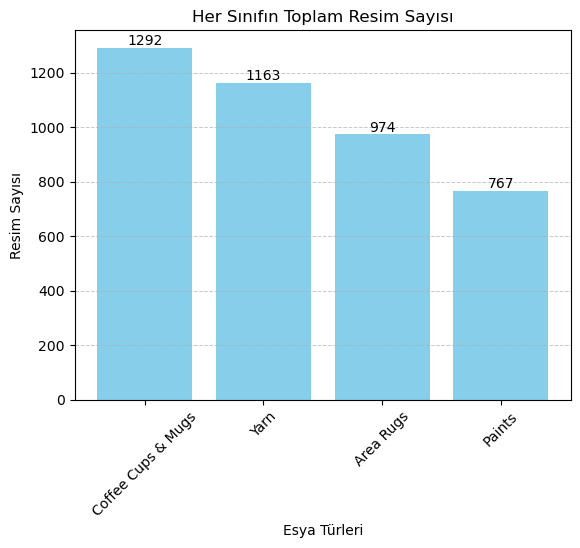

In [18]:
# Türleri tanımlayalim
classes = ['Coffee Cups & Mugs', 'Yarn', 'Area Rugs', 'Paints']

# Resimlerin bulunduğu dizini tanımlayın
data_dir = r"C:\\Users\\ypb23112\\OneDrive - University of Strathclyde\\Desktop\\DL 1\\Model_Final\\Model_1\\Product_Images"

# Her sınıf için toplam resim sayısını hesaplayalim
total_counts = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len([fname for fname in os.listdir(class_dir) if fname.endswith('.jpg')])
    total_counts.append(num_images)

# Toplam resim sayılarını bir barplot ile gösterelim
plt.bar(classes, total_counts, color='skyblue')
plt.xlabel('Esya Türleri')
plt.ylabel('Resim Sayısı')
plt.title('Her Sınıfın Toplam Resim Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7)

# Barlarin üzerine değerleri yazdıralim; 
for i, count in enumerate(total_counts):
    plt.text(i, count, str(count), ha='center', va='bottom') 
    
# Toplam resim sayısını da hesaplayalim
total_images = sum(total_counts)
print('Toplam: ',total_images,' adet resim var.')

**Yorum:** There are 4 classes and total 4196 image in dataset.

## Verileri train ve test olarak ayir

In [14]:
# Verileri train ve test olarak iki ust klasore ayiralim;

#mevcut klasorun yolunu tanittik;
data_folder = r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\Product_Images"

#Train ve test klasörlerini oluşturalim:
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

#Her sınıf için train ve test klasörlerini oluşturalim:
classes = ['Coffee Cups & Mugs', 'Yarn', 'Area Rugs', 'Paints']

for flower_class in classes:
    # Sınıfa ait train ve test klasörlerini oluşturun
    train_class_folder = os.path.join(train_folder, flower_class)
    test_class_folder = os.path.join(test_folder, flower_class)

    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

# Verileri train ve test klasörlerine kopyalayın. Örneğin, her sınıfın %80'i train, %20'si test olarak ayırmak isterseniz:
import random

split_ratio = 0.8  # Train için %80, Test için %20
for flower_class in classes:
    flower_images = os.listdir(os.path.join(data_folder, flower_class))
    random.shuffle(flower_images)  # Verileri rastgele sıralayın

    split_index = int(len(flower_images) * split_ratio)

    # Train klasörüne kopyala
    for image in flower_images[:split_index]:
        src = os.path.join(data_folder, flower_class, image)
        dest = os.path.join(train_folder, flower_class, image)
        shutil.copy(src, dest)

    # Test klasörüne kopyala
    for image in flower_images[split_index:]:
        src = os.path.join(data_folder, flower_class, image)
        dest = os.path.join(test_folder, flower_class, image)
        shutil.copy(src, dest)

## Train ve Test Pathlerini Tannimlayalim  

In [19]:
# Data setini okuyalim ve ilgili pathlere atayalim; 
train_path = r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\Product_Images\train"
test_path = r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\Product_Images\test"

class_names = os.listdir(train_path)
class_names

['Area Rugs', 'Coffee Cups & Mugs', 'Paints', 'Yarn']

## Look at the Classes and Image Numbers at Train Dataset 

In [20]:
total_train = 0
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(train_path + "/" + i)))
    total_train += len(os.listdir(train_path + "/" + i))
print("Total train images : ", total_train)

Number of Area rugs images: 779
Number of Coffee cups & mugs images: 1033
Number of Paints images: 613
Number of Yarn images: 930
Total train images :  3355


## Look at the Classes and Image Numbers at Test Dataset

In [21]:
total_test = 0
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(test_path + "/" + i)))
    total_test += len(os.listdir(test_path + "/" + i))
print("Total test images : ", total_test)

Number of Area rugs images: 195
Number of Coffee cups & mugs images: 259
Number of Paints images: 154
Number of Yarn images: 233
Total test images :  841


## Resimlere bakalim

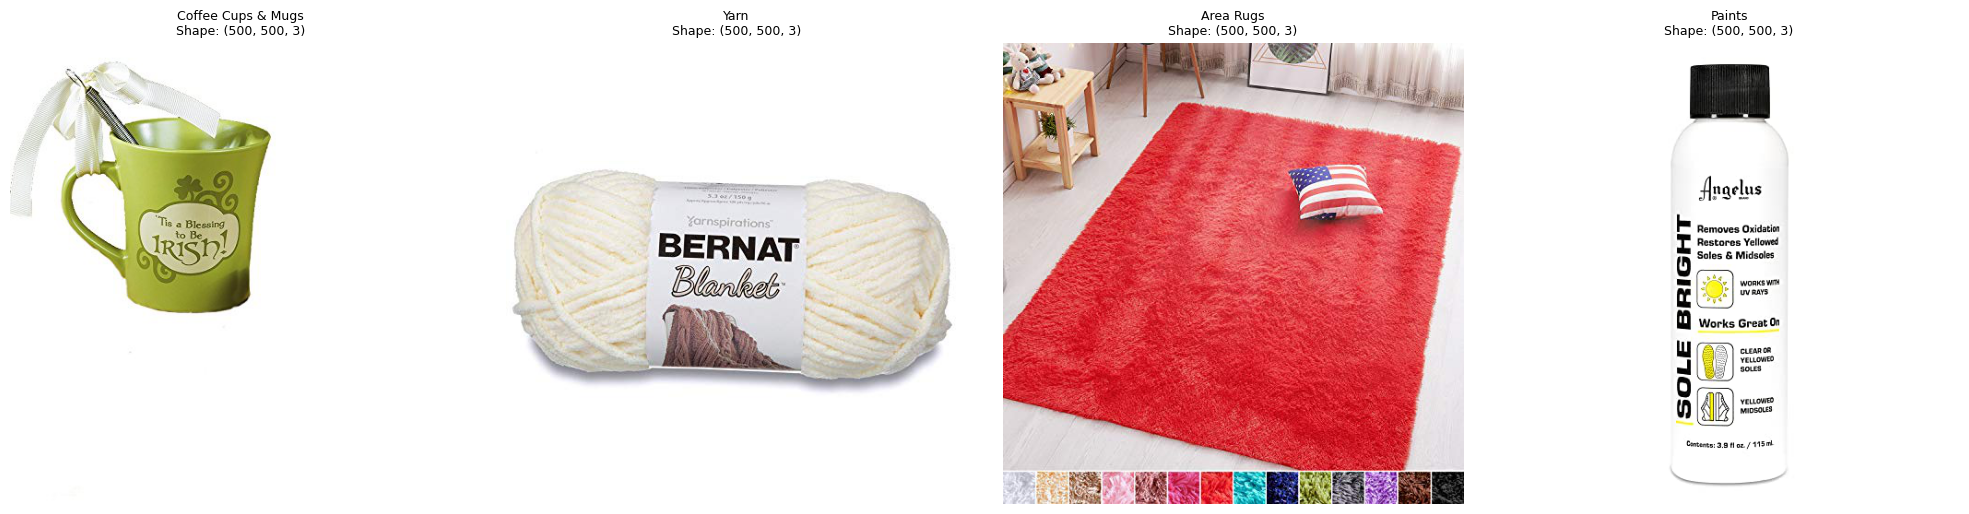

In [18]:
# Traindeki her turden 1 tane resim secip bakalim;
classes = ["Coffee Cups & Mugs", "Yarn", "Area Rugs", "Paints"]

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_path, class_name)

    # Bu sınıf için ilk resmin yolu
    first_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])

    # Resmi açın
    img = Image.open(first_image_path)

    # Resmi bir numpy dizisine çevirin
    img_array = np.array(img)

    # Resmi görselleştirin
    axes[i].imshow(img)
    axes[i].set_title(f"{class_name}\nShape: {img_array.shape}", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Resimlerin Olculerine Bakalim

In [10]:
#pip install scikit-image

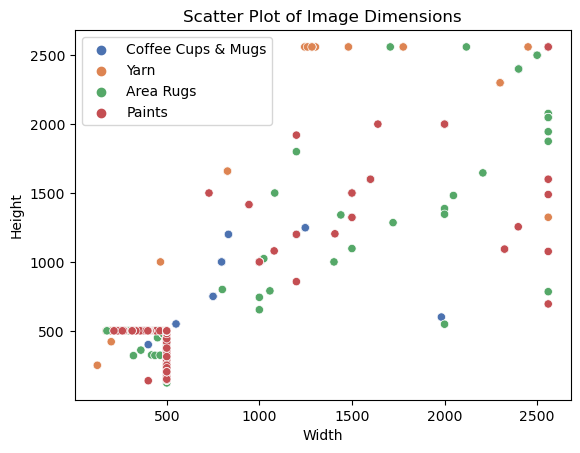

In [11]:
# Elimizdeki (traindeki) resimlerin ortalama olculerini bulmak istiyoruz;
x = []
y = []
hue = []

for class_name in classes:
    class_dir = os.path.join(train_path, class_name)

    for image_name in os.listdir(class_dir):
        if image_name.endswith('.jpg'):  # Sadece .jpg dosyalarını işle
            img = imread(os.path.join(class_dir, image_name))
            d1, d2, colors = img.shape
            x.append(d1)
            y.append(d2)
            hue.append(class_name)

sns.scatterplot(x=x, y=y, hue=hue, palette="deep")
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Scatter Plot of Image Dimensions')
plt.show()

In [44]:
keras.__version__

'2.13.1'

In [45]:
tf.__version__

'2.13.0'

In [12]:
print(np.mean(x), np.mean(y))

590.8864381520119 589.3833084947839


###  Final Image Size

**Streamlitte sorun yasamamak icin 224 x 224 ile devam et**

In [25]:
# Standart bir image size belirleyelim (Transfer Learnin modelerinin kendilerinin bekledigi farkli olculer de olabiliyor ona dikkat et!); 
image_shape = (224,224,3) 

## Resimlerin Pixel Degerlerine Bakalim

In [13]:
path1=train_path+'/Yarn'+'/image_485.jpg'

In [14]:
Yarn_img=imread(path1)

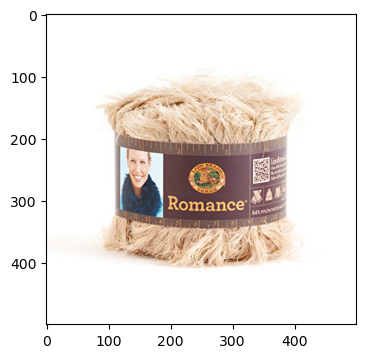

In [15]:
plt.figure(figsize=(4,5))
plt.imshow(Yarn_img);

In [16]:
Yarn_img.max()

255

In [17]:
Yarn_img.min()

0

**Yorum:** Resimlerin pixel olculeru resize edilmemis (255'e bolunmemis) durumda. 

# Manuel CNN Model

## Image Generator for Manuel CNN

In [59]:
# Train datasindaki image'leri cogaltacagiz ki moel daha iyi ogrensin. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Generator islemini sadece train datasina uygulayacagiz;
image_gen_train = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               rescale=1/255, # resimlerin pixel degerlerini 255'e bolerek degerleri (0,1) araligina tasiyoruz (scalling islemi yapiyoruz)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allowe horizontal flipping
                               fill_mode='nearest') # Fill in missing pixels with the nearest filled value

#-----------------------------------------------------
# Test datasinda img gen yapmiyoruz. 
# Boylece sinamayi test datasinin orijinal hallerini kullanarak gerceklestirmek istiyoruz;

image_gen_test = ImageDataGenerator(rescale=1/255) # burada sadece scaling uyguluyoruz, resmi dondurerek vb degistirmiyoruz.  

#**********************************************************************************************
# Img Gen'i train ve test datalarina uygulayalim;

batch_size = 62 # default degeri 32

train_image_gen = image_gen_train.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True)

test_image_gen = image_gen_test.flow_from_directory(test_path,
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical', 
                                               shuffle=False)

Found 3355 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [159]:
train_image_gen.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [150]:
test_image_gen.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### Rescaling Sonucunda Resimlerin Pixel Degerlerine Bakalim

In [52]:
train_image_gen.next()[0][0].max() 

1.0

In [53]:
train_image_gen.next()[0][0].min() 

0.0

In [84]:
test_image_gen.next()[0][0].max() 

1.0

In [85]:
test_image_gen.next()[0][0].min() 

0.0

**Yorum:** Rescaling islemi basarili olmus, renk kodlari (0,1) arasinda degisir hale getirilmistir. 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

In [61]:
manuel_CNN_model = Sequential()

image_shape = (224,224,3) 
# 1. Katman;
manuel_CNN_model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 input_shape=image_shape, 
                 activation='relu', 
                 padding = 'same')) #padding = 'same': 0 ekle
manuel_CNN_model.add(BatchNormalization())
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
manuel_CNN_model.add(Dropout(0.3))

# 2. Katman;
manuel_CNN_model.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 activation='relu', 
                 padding = 'same'))
manuel_CNN_model.add(BatchNormalization())
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
manuel_CNN_model.add(Dropout(0.3))

# 3. Katman;
manuel_CNN_model.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 activation='relu', 
                 padding = 'same'))
manuel_CNN_model.add(BatchNormalization())
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
manuel_CNN_model.add(Dropout(0.3))

# 4. Katman;
manuel_CNN_model.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 activation='relu', 
                 padding = 'same'))
manuel_CNN_model.add(BatchNormalization())
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
manuel_CNN_model.add(MaxPooling2D(pool_size=(2, 2))) # Fletten 50.000 lerdeydi azaltabilmek icin birden fazla pooling kullandim.
manuel_CNN_model.add(Dropout(0.3))


#Flatten (Input) Katmani
manuel_CNN_model.add(Flatten())

# ---ANN---

# Fully_connected layer;
manuel_CNN_model.add(Dense(128, activation='relu'))
manuel_CNN_model.add(BatchNormalization())
manuel_CNN_model.add(Dropout(0.3))

# Cikis Katmani; 
manuel_CNN_model.add(Dense(4, activation='softmax')) # 4 class var, activation fonlsiyonu da bu nedenle "softmax". 2 class olsaydi sigmoid kullanirdik.


# Modeli compile edelim; 
optimizer = Adam(learning_rate=0.001)
manuel_CNN_model.compile(loss='categorical_crossentropy', # 2 class olsaydi 'binary_crossentropy' olurdu.
              optimizer=optimizer,              
              metrics=['accuracy'])

## Early Stopping

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

## Model Ozeti

In [63]:
manuel_CNN_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_13 (Ba  (None, 112, 112, 128)    

In [64]:
manuel_CNN_results = manuel_CNN_model.fit(train_image_gen,
                    epochs=50,
                    validation_data = test_image_gen,
                    callbacks = [early_stop])

Epoch 1/50
55/55 [==============================] - 327s 6s/step - loss: 0.6599 - accuracy: 0.7717 - val_loss: 1.8362 - val_accuracy: 0.2331
Epoch 2/50
55/55 [==============================] - 324s 6s/step - loss: 0.3405 - accuracy: 0.8820 - val_loss: 3.8863 - val_accuracy: 0.2319
Epoch 3/50
 7/55 [==>...........................] - ETA: 4:31 - loss: 0.3597 - accuracy: 0.8710

KeyboardInterrupt: 

## Evaluating the Model

In [165]:
manuel_CNN_summary = pd.DataFrame(manuel_CNN_model.history.history)
manuel_CNN_summary.tail()

,loss,accuracy,val_loss,val_accuracy
0,0.631281,0.775261,3.782504,0.231867
1,0.352233,0.884054,3.786695,0.231867
2,0.276193,0.906408,3.043577,0.231867


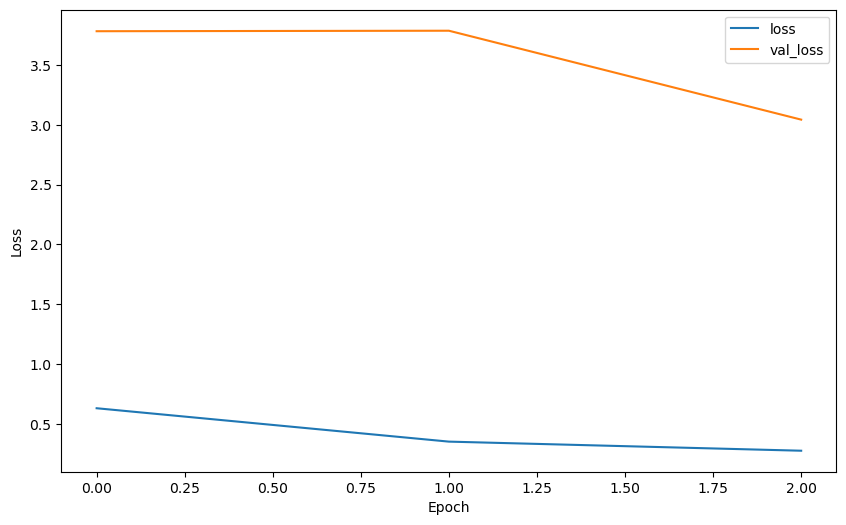

In [166]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(manuel_CNN_summary.loss, label="loss")
plt.plot(manuel_CNN_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

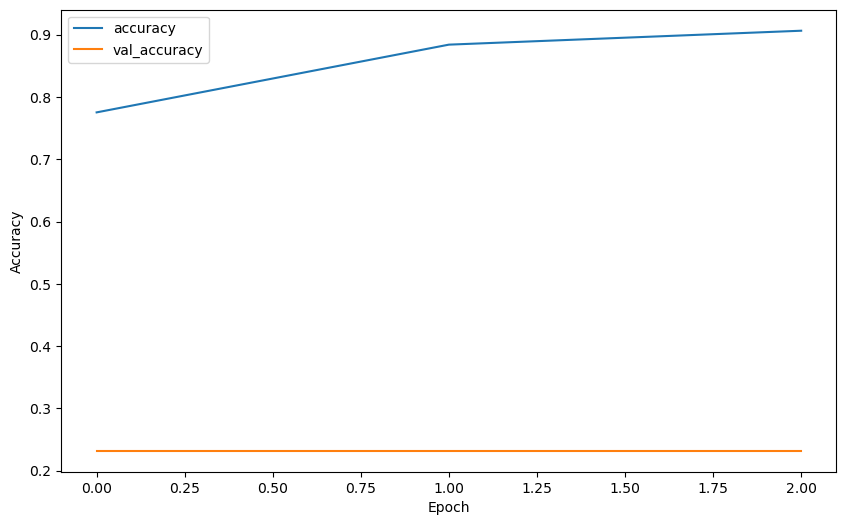

In [167]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(manuel_CNN_summary.accuracy, label="accuracy")
plt.plot(manuel_CNN_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
#Filiz H. 

#Get Predictions;
Xception_model_pred_probabilities = Xception_model.predict(test_image_gen)
Xception_model_pred_probabilities

# Transform Probabilites to Clasesses 
Xception_model_probs = np.array(Xception_model_pred_probabilities)
Xception_model_predictions = np.argmax(Xception_model_probs, axis=1)

# Predictions
print("Predictions: ", Xception_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

In [ ]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, Xception_model_predictions))
print(classification_report(test_image_gen.classes, Xception_model_predictions))

### Save the Model

In [76]:
from tensorflow.keras.models import load_model
manuel_CNN_model.save('Manuel_CNN.h5')

In [ ]:
# With Keras
from tensorflow.keras.models import load_model
manuel_CNN_model.save('manuel_CNN.keras')

# TRANSFER LEARNING MODELS

## Image Generator for Transfer Learning Models
Bunu buraya bir daha almamin nedeni; rescaling isleminin Manuel CNN'de bizim tarafimizdan yapilirken, 

Transfer Learning'de icsel olarak yapilacak olmasidir. 

In [22]:
# Train datasindaki image'leri cogaltacagiz ki moel daha iyi ogrensin. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Generator islemini sadece train datasina uygulayacagiz;
image_gen_train = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allowe horizontal flipping
                               fill_mode='nearest') # Fill in missing pixels with the nearest filled value

# Ustte "rescale=1/255" de vardi sildim, cunku Transfer Learning modelleri bunu istemiyor. 
# Bunu Manle CNN'de manule yapip, Transfer Learning'de otomatik yaptiracagiz.
#-----------------------------------------------------
# Test datasinda img gen yapmiyoruz. 
# Boylece sinamayi test datasinin orijinal hallerini kullanarak gerceklestirmek istiyoruz;

image_gen_test = ImageDataGenerator() # bunu bos da olsa yapmamin nedeni; asagida buna ihtiyacimin olmasi. 

#**********************************************************************************************
# Img Gen'i train ve test datalarina uygulayalim;

batch_size = 32 # default degeri 32

train_image_gen = image_gen_train.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True)

test_image_gen = image_gen_test.flow_from_directory(test_path,
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 3355 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


# XCeption  (Yeni Sistemle)

**Bu modelde Rescaling kendi icinde otomatik yapilmiyor.** 

**preprocessing =True yok.** https://keras.io/api/applications/xception/

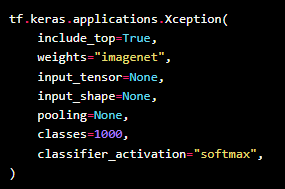

**Rescaling islemini biz yaptiracagiz modelde:**  

Bunun icin kullanacagimiz kod: **tf.keras.applications.xception.preprocess_input**



### Set the Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import xception
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
# Bu satirda xception ilk sirada kucuk, ikinci sirada buyuk harfle baslamali.

# Xception modelini çağıralım
Xception_model = Sequential() 

#---Preprocessing Islemi Basliyor---
# Xception modelinin giriş katmanını ekleyelim
Xception_model.add(keras.Input(shape=(224, 224, 3)))  # Xception için varsayılan giriş boyutu 299x299

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyin
Xception_model.add(Lambda(xception.preprocess_input))
#-----Preprocessing Islemi Bitti----

# Önceden indirilmiş ağırlıkları kullanalım
pretrained_model = Xception(include_top=False,
                            input_shape=(224, 224, 3), #Xception egitilirken kullanilan olculer bunlar. Biz de burada resimleriizi ayni olcuye donusturduk. 
                            weights='imagenet', # 'imagenet',  # Önceden indirilmiş ağırlıkları kullan
                            pooling='avg',
                            classifier_activation="softmax")

# Xception'ın ağırlıklarını eğitilemez yapalım
for layer in pretrained_model.layers:
    layer.trainable = False

Xception_model.add(pretrained_model)  

# Flatten Layer (Input)
Xception_model.add(Flatten())

# ---ANN---

# Fully_connected layer;
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(BatchNormalization())
Xception_model.add(Dropout(0.3))

# Cikis Katmani; 
Xception_model.add(Dense(4, activation='softmax')) # 4 class var, softmax multiclass 

# Modeli compile edelim; 
optimizer = Adam(learning_rate=0.001)
Xception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,              
              metrics=['accuracy'])     

# Callback'leri tanımlayalım
early_stop = EarlyStopping(monitor='val_loss', patience=10)


# Model özeti
Xception_model.summary()

83683744/83683744 [==============================] - 27s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)              

### Model Training

In [40]:
Xception_model_results = Xception_model.fit(train_image_gen,epochs=50,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/50
105/105 [==============================] - 203s 2s/step - loss: 0.0878 - accuracy: 0.9759 - val_loss: 0.0445 - val_accuracy: 0.9857
Epoch 2/50
105/105 [==============================] - 190s 2s/step - loss: 0.0239 - accuracy: 0.9940 - val_loss: 0.0390 - val_accuracy: 0.9881
Epoch 3/50
105/105 [==============================] - 200s 2s/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0473 - val_accuracy: 0.9905
Epoch 4/50
105/105 [==============================] - 195s 2s/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0523 - val_accuracy: 0.9893
Epoch 5/50
105/105 [==============================] - 194s 2s/step - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0326 - val_accuracy: 0.9929
Epoch 6/50
105/105 [==============================] - 192s 2s/step - loss: 0.0158 - accuracy: 0.9940 - val_loss: 0.0347 - val_accuracy: 0.9917
Epoch 7/50
105/105 [==============================] - 193s 2s/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0451 - val_accuracy: 0.9905

### Evaluate the Model

In [41]:
Xception_summary = pd.DataFrame(Xception_model.history.history)
Xception_summary.tail()

,loss,accuracy,val_loss,val_accuracy
10,0.003236,0.999106,0.056549,0.991677
11,0.004348,0.998510,0.035768,0.994055
12,0.003058,0.999106,0.040051,0.994055
13,0.005678,0.997616,0.045217,0.990488
14,0.005024,0.998212,0.062450,0.989298


#### 244x244 ile de çalıştırıldı ve şu sonuç verdi:
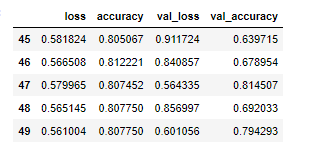

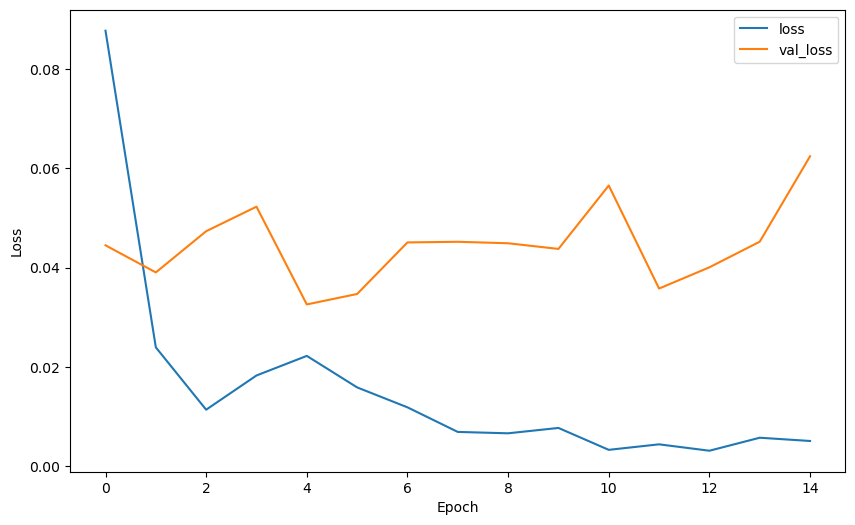

In [42]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(Xception_summary.loss, label="loss")
plt.plot(Xception_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

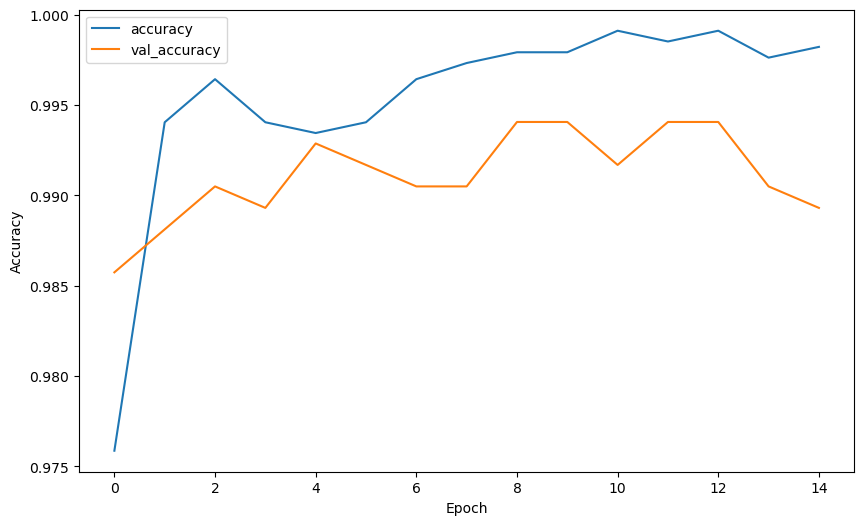

In [43]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(Xception_summary.accuracy, label="accuracy")
plt.plot(Xception_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [44]:
#Get Predictions;
Xception_model_pred_probabilities = Xception_model.predict(test_image_gen)
Xception_model_pred_probabilities
# Transform Probabilites to Clasesses
Xception_model_probs = np.array(Xception_model_pred_probabilities)
Xception_model_predictions = np.argmax(Xception_model_probs, axis=1)
# Predictions
print("Predictions: ", Xception_model_predictions[:50])
# Actual Values
print("Actual     : ", test_image_gen.classes[:50])
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, Xception_model_predictions))
print(classification_report(test_image_gen.classes, Xception_model_predictions))

27/27 [==============================] - 35s 1s/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[194   0   1   0]
 [  1 257   1   0]
 [  0   3 151   0]
 [  1   1   1 230]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       195
           1       0.98      0.99      0.99       259
           2       0.98      0.98      0.98       154
           3       1.00      0.99      0.99       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



### Save the Model

In [46]:
from tensorflow.keras.models import load_model
Xception_model.save('Xception.h5')

In [47]:
from tensorflow.keras.models import load_model
Xception_model.save('Xception.keras')

# VGG16

**Since scaling is not embedded in VGG16.** 

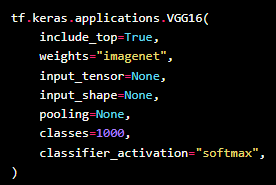

https://keras.io/api/applications/

**We should add preprocessing.** 


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# VGG16 modelini include_top=False ile oluşturun
base_model = VGG16(weights=None, 
                   include_top=False, 
                   input_shape=(224, 224, 3), 
                   pooling='avg')

# Ağırlıkları mauel yükleyin
base_model.load_weights(r'C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Yeni bir Sequential model oluşturun ve base_model katmanlarını ekleyin
VGG16_model = Sequential(base_model.layers)

# Özel katmanlarınızı ekleyin
VGG16_model.add(Flatten())
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(BatchNormalization())
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(4, activation='softmax'))

# Modelin katmanlarını dondurun (isteğe bağlı)
for layer in VGG16_model.layers[:-5]: # Yalnızca yeni eklediğiniz katmanlar eğitilebilir olmalı
    layer.trainable = False

# Modeli derleyin
optimizer = Adam(learning_rate=0.001)
VGG16_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,              
                    metrics=['accuracy'])     

# Model özetini yazdır
VGG16_model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

### Train the Model

In [49]:
VGG16_model_results = VGG16_model.fit(train_image_gen,epochs=50,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/50
105/105 [==============================] - 489s 5s/step - loss: 0.1084 - accuracy: 0.9675 - val_loss: 0.0420 - val_accuracy: 0.9869
Epoch 2/50
105/105 [==============================] - 481s 5s/step - loss: 0.0305 - accuracy: 0.9914 - val_loss: 0.0404 - val_accuracy: 0.9881
Epoch 3/50
105/105 [==============================] - 477s 5s/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0174 - val_accuracy: 0.9917
Epoch 4/50
105/105 [==============================] - 471s 4s/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.0213 - val_accuracy: 0.9905
Epoch 5/50
105/105 [==============================] - 476s 5s/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 6/50
105/105 [==============================] - 449s 4s/step - loss: 0.0062 - accuracy: 0.9976 - val_loss: 0.0243 - val_accuracy: 0.9917
Epoch 7/50
105/105 [==============================] - 447s 4s/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0347 - val_accuracy: 0.9881

### Evaluate the model

In [50]:
VGG16_summary = pd.DataFrame(VGG16_model.history.history)
VGG16_summary.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.002442,0.998510,0.017176,0.992866
21,0.002292,0.999106,0.016988,0.991677
22,0.005518,0.997317,0.023896,0.991677
23,0.007571,0.997616,0.048703,0.990488
24,0.002849,0.998808,0.025042,0.994055


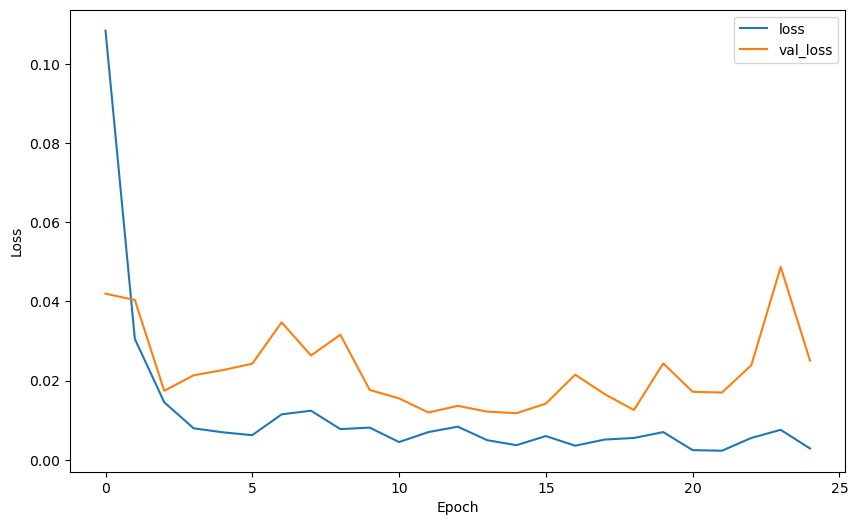

In [51]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(VGG16_summary.loss, label="loss")
plt.plot(VGG16_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

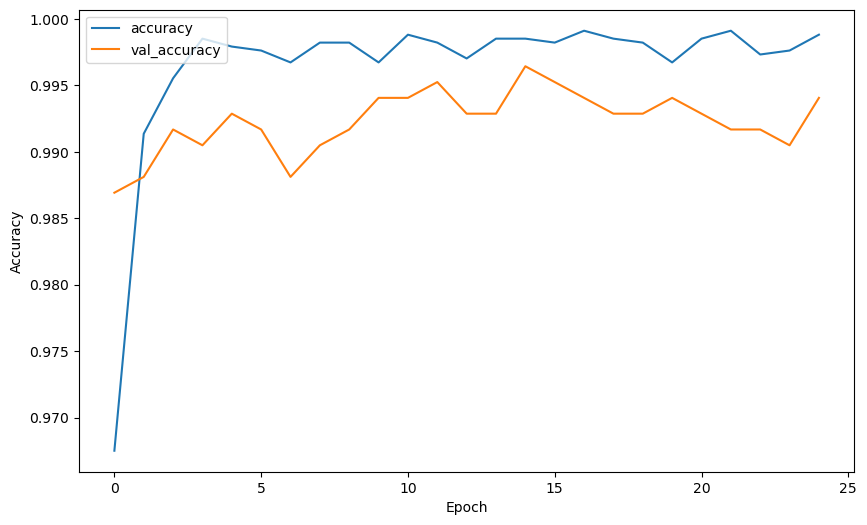

In [52]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(VGG16_summary.accuracy, label="accuracy")
plt.plot(VGG16_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [53]:
#Get Predictions;
VGG16_model_pred_probabilities = VGG16_model.predict(test_image_gen)
VGG16_model_pred_probabilities

# Transform Probabilites to Clasesses 
VGG16_model_probs = np.array(VGG16_model_pred_probabilities)
VGG16_model_predictions = np.argmax(VGG16_model_probs, axis=1)

# Predictions
print("Predictions: ", VGG16_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

27/27 [==============================] - 81s 3s/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [54]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, VGG16_model_predictions))
print(classification_report(test_image_gen.classes, VGG16_model_predictions))

[[194   1   0   0]
 [  0 257   1   1]
 [  1   0 153   0]
 [  1   0   0 232]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       195
           1       1.00      0.99      0.99       259
           2       0.99      0.99      0.99       154
           3       1.00      1.00      1.00       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



###  Save the Model

In [56]:
from tensorflow.keras.models import load_model
VGG16_model.save('VGG16.h5')

In [38]:
from tensorflow.keras.models import load_model
VGG16_model.save('VGG16.keras')

# ResNet152

**Since scaling is not embedded in ResNet152, we should scaled our data in here.**
https://keras.io/api/applications/resnet/#resnet152-function
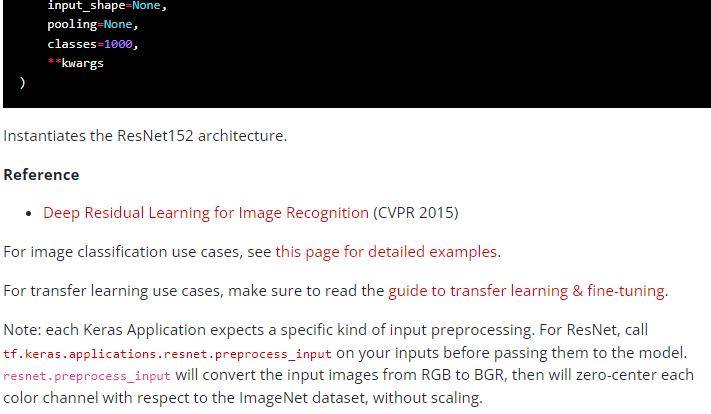

In [19]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions


from keras.models import Sequential
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

# Xception modelini çağıralım
ResNet152_model = Sequential() 

#---Preprocessing İşlemi Başlıyor---
# Xception modelinin giriş katmanını ekleyelim
ResNet152_model.add(keras.Input(shape=(224, 224, 3))) 

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyin
ResNet152_model.add(Lambda(resnet.preprocess_input))
#-----Preprocessing İşlemi Bitti----

# Önceden indirilmiş ağırlıkları kullanalım
pretrained_model = ResNet152(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet',  # Önceden indirilmiş ağırlıkları kullan
                            pooling='avg',
                            classifier_activation="softmax")

# Xception'ın ağırlıklarını eğitilemez yapalım
for layer in pretrained_model.layers:
    layer.trainable = False

ResNet152_model.add(pretrained_model)  

# Flatten Layer (Input)
ResNet152_model.add(Flatten())

# ---ANN---

# Fully_connected layer;
ResNet152_model.add(Dense(512, activation='relu'))
ResNet152_model.add(BatchNormalization())
ResNet152_model.add(Dropout(0.3))

# Çıkış Katmanı; 
ResNet152_model.add(Dense(4, activation='softmax')) # 4 class var, softmax multiclass 

# Modeli compile edelim; 
optimizer = Adam(learning_rate=0.001)
ResNet152_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,              
              metrics=['accuracy'])     

# Callback'leri tanımlayalım
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Model özeti
ResNet152_model.summary()

234698864/234698864 [==============================] - 137s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)             

### Early Stopping¶

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

### Train the Model

In [21]:
ResNet152_model_results = ResNet152_model.fit(train_image_gen,epochs=50,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/50
105/105 [==============================] - 515s 5s/step - loss: 0.0724 - accuracy: 0.9791 - val_loss: 0.0484 - val_accuracy: 0.9905
Epoch 2/50
105/105 [==============================] - 538s 5s/step - loss: 0.0128 - accuracy: 0.9946 - val_loss: 0.0279 - val_accuracy: 0.9905
Epoch 3/50
105/105 [==============================] - 531s 5s/step - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.0270 - val_accuracy: 0.9941
Epoch 4/50
105/105 [==============================] - 510s 5s/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0313 - val_accuracy: 0.9905
Epoch 5/50
105/105 [==============================] - 509s 5s/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.0353 - val_accuracy: 0.9917
Epoch 6/50
105/105 [==============================] - 505s 5s/step - loss: 0.0030 - accuracy: 0.9982 - val_loss: 0.0424 - val_accuracy: 0.9881
Epoch 7/50
105/105 [==============================] - 510s 5s/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.0411 - val_accuracy: 0.9905

###  Evaluate the Model

In [22]:
ResNet152_summary = pd.DataFrame(ResNet152_model.history.history)
ResNet152_summary.tail()

,loss,accuracy,val_loss,val_accuracy
8,0.003563,0.999106,0.031940,0.994055
9,0.005766,0.998510,0.037026,0.992866
10,0.003580,0.998808,0.049445,0.989298
11,0.003335,0.998808,0.033128,0.992866
12,0.001909,0.999702,0.032342,0.990488


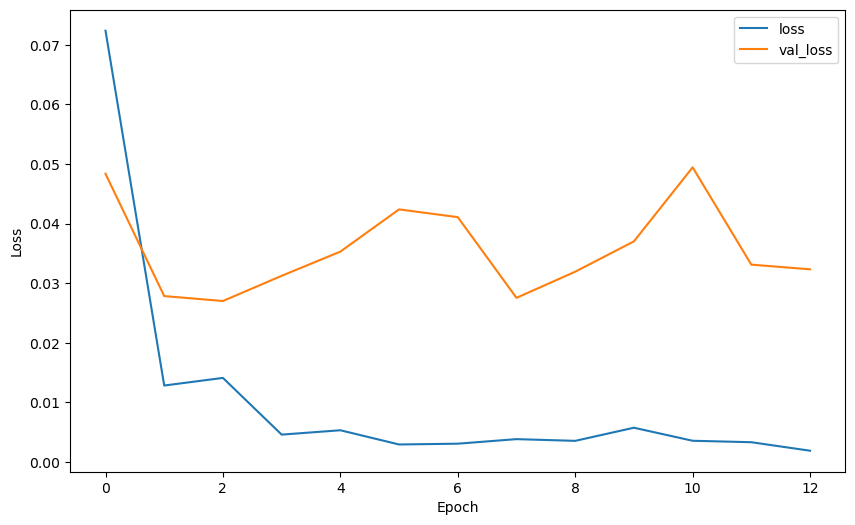

In [23]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(ResNet152_summary.loss, label="loss")
plt.plot(ResNet152_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

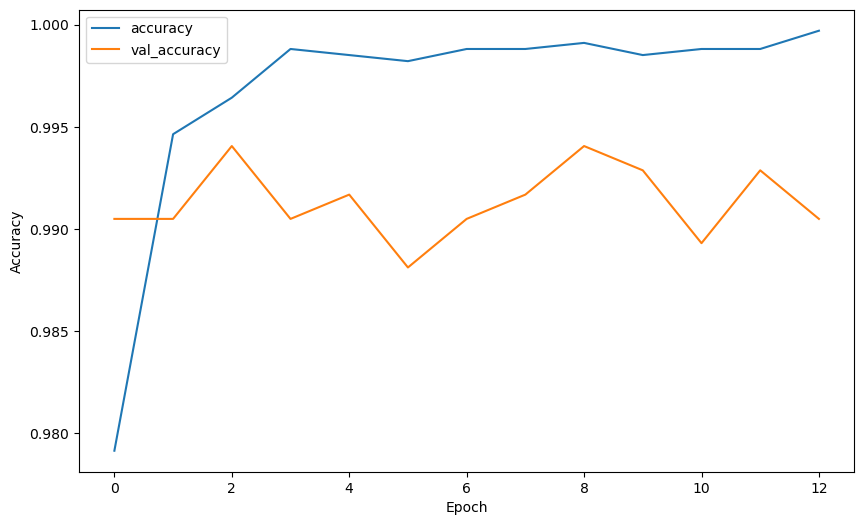

In [24]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(ResNet152_summary.accuracy, label="accuracy")
plt.plot(ResNet152_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [25]:
#Get Predictions;
ResNet152_model_pred_probabilities = ResNet152_model.predict(test_image_gen)
ResNet152_model_pred_probabilities

# Transform Probabilites to Clasesses 
ResNet152_model_probs = np.array(ResNet152_model_pred_probabilities)
ResNet152_model_predictions = np.argmax(ResNet152_model_probs, axis=1)

# Predictions
print("Predictions: ", ResNet152_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

27/27 [==============================] - 126s 4s/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, ResNet152_model_predictions))
print(classification_report(test_image_gen.classes, ResNet152_model_predictions))

[[194   0   1   0]
 [  0 257   2   0]
 [  0   2 152   0]
 [  1   0   2 230]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       195
           1       0.99      0.99      0.99       259
           2       0.97      0.99      0.98       154
           3       1.00      0.99      0.99       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



In [27]:
#Get Predictions;
ResNet152_model_pred_probabilities1 = ResNet152_model.predict(train_image_gen)
ResNet152_model_pred_probabilities1

# Transform Probabilites to Clasesses 
ResNet152_model_probs1 = np.array(ResNet152_model_pred_probabilities1)
ResNet152_model_predictions1 = np.argmax(ResNet152_model_probs1, axis=1)

# Predictions
print("Predictions: ", ResNet152_model_predictions1[:50])

# Actual Values
print("Actual     : ", train_image_gen.classes[:50])

105/105 [==============================] - 467s 4s/step
Predictions:  [3 3 1 0 3 3 1 1 0 3 3 1 0 2 0 1 2 2 3 3 2 1 0 3 3 1 0 2 1 0 0 0 2 3 3 0 3
 3 3 1 0 2 1 2 1 3 1 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Save the Model

In [29]:
from tensorflow.keras.models import load_model
ResNet152_model.save('ResNet152.h5')

In [30]:
from tensorflow.keras.models import load_model
ResNet152_model.save('ResNet152.keras')

#  InceptionV3

Prerpcessing yok, biz yapacagiz.

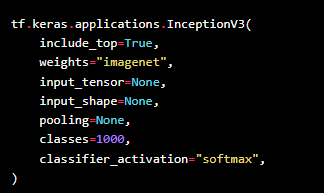

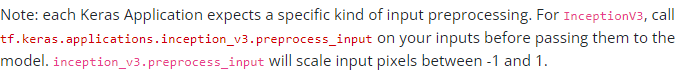

In [67]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Sequential modeli oluşturalim
InceptionV3_model = Sequential()

#---Preprocessing Islemi Basliyor---
# InceptionV3 modelinin giriş katmanını ekleyelim
InceptionV3_model.add(keras.Input(shape=(224, 224, 3)))  # InceptionV3 için varsayılan giriş boyutu 299x299 ama streamlitte ayni olmasi icin bunu yazdim

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyelim
InceptionV3_model.add(Lambda(inception_v3.preprocess_input))
#---Preprocessing Islemi Bitti---

# Önceden eğitilmiş InceptionV3 modeline ait bilgileri ekleyelim
pretrained_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights=None, #'imagenet' olunca skorlar daha iyi oluyor. Ben bunu manuel hallediyorum
                                                     pooling='avg')

# Ağırlık dosyasının yolunu belirleyin
weights_path = r'C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Ağırlıkları modele yükleyin
pretrained_model.load_weights(weights_path)

# InceptionV3'nin ağırlıklarını kullanalım
for layer in pretrained_model.layers:
    layer.trainable = False

InceptionV3_model.add(pretrained_model)

#----------------------------
# Flatten Layer (Input)
InceptionV3_model.add(Flatten())

# Flatten yerine bu da kullanilabilir
# InceptionV3_model.add(GlobalAveragePooling2D())
#-----------------------------

# ---ANN---

# Fully Connected Layer
InceptionV3_model.add(Dense(512, activation='relu'))
InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dropout(0.3))

# Çıkış Katmanı
InceptionV3_model.add(Dense(4, activation='softmax'))

# Optimizer olarak özelleştirilmiş Adam optimizer kullanılır
optimizer = Adam(learning_rate=0.001) # Baslangic learning  rate degerimiz. LR asagida optimize edilecek. 


# Modeli derleyelim (Compile edelim)
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])



#LR'i optimize ediyoruz;
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001) 
# baslangic lr ile basla, val_loss 3 adim boyunca dusmezse lr ile factor oranini carparak lr yi dusur 
# ve yola yeni lr ile devam et. Bu isleme lr min 0.0001 olana kadar devam et demis olduk. 

InceptionV3_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_19 (Lambda)          (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_946 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                     

### Early Stopping

In [68]:
# Callbacks tanımlanır
early_stop = EarlyStopping(monitor='val_loss', patience=10)

### Train the Model

In [70]:
InceptionV3_model_results = InceptionV3_model.fit(train_image_gen,epochs=5,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/5
105/105 [==============================] - 129s 1s/step - loss: 0.0430 - accuracy: 0.9857 - val_loss: 0.0453 - val_accuracy: 0.9881
Epoch 2/5
105/105 [==============================] - 122s 1s/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0387 - val_accuracy: 0.9881
Epoch 3/5
105/105 [==============================] - 123s 1s/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.0918 - val_accuracy: 0.9822
Epoch 4/5
105/105 [==============================] - 123s 1s/step - loss: 0.0197 - accuracy: 0.9925 - val_loss: 0.0391 - val_accuracy: 0.9905
Epoch 5/5
105/105 [==============================] - 122s 1s/step - loss: 0.0147 - accuracy: 0.9949 - val_loss: 0.0361 - val_accuracy: 0.9917


###  Evaluate the model

In [71]:
InceptionV3_summary = pd.DataFrame(InceptionV3_model.history.history)
InceptionV3_summary.tail()

,loss,accuracy,val_loss,val_accuracy
0,0.043046,0.985693,0.045294,0.988109
1,0.025783,0.991952,0.038725,0.988109
2,0.017262,0.995231,0.091842,0.982164
3,0.019681,0.992548,0.039060,0.990488
4,0.014722,0.994933,0.036139,0.991677


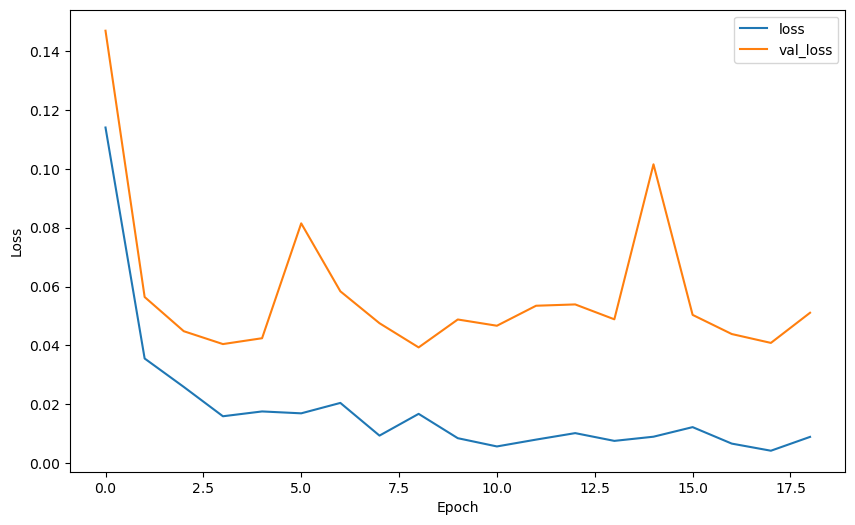

In [37]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(InceptionV3_summary.loss, label="loss")
plt.plot(InceptionV3_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

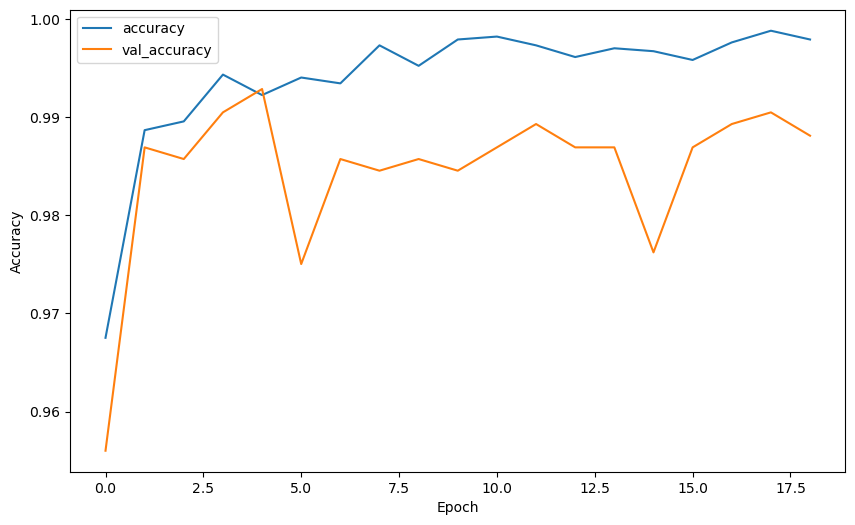

In [38]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(InceptionV3_summary.accuracy, label="accuracy")
plt.plot(InceptionV3_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [39]:
#Get Predictions;
InceptionV3_model_pred_probabilities = InceptionV3_model.predict(test_image_gen)
InceptionV3_model_pred_probabilities
# Transform Probabilites to Clasesses
InceptionV3_model_probs = np.array(InceptionV3_model_pred_probabilities)
InceptionV3_model_predictions = np.argmax(InceptionV3_model_probs, axis=1)
# Predictions
print("Predictions: ", InceptionV3_model_predictions[:50])
# Actual Values
print("Actual     : ", test_image_gen.classes[:50])
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, InceptionV3_model_predictions))
print(classification_report(test_image_gen.classes, InceptionV3_model_predictions))

27/27 [==============================] - 24s 766ms/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[194   1   0   0]
 [  0 258   1   0]
 [  1   0 153   0]
 [  2   3   2 226]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       195
           1       0.98      1.00      0.99       259
           2       0.98      0.99      0.99       154
           3       1.00      0.97      0.98       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



###  Save the Model

In [74]:
from tensorflow.keras.models import load_model
InceptionV3_model.save('InceptionV3.h5')

In [13]:
from tensorflow.keras.models import load_model
InceptionV3_model.save('InceptionV3ismet.keras')

# MobilNetV2
**Img preprocessing yok**

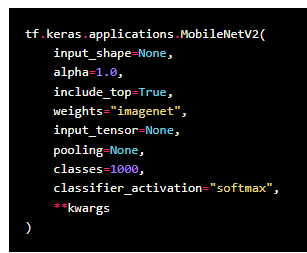

**Kendimiz  ekleyecegiz.** 


In [23]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda

# MobileNetV2 Sequential modeli oluşturun
MobileNetV2_model = Sequential()

#----Preprosseing Basladi------------
# MobileNetV2 modelinin giriş katmanını ekleyin
MobileNetV2_model.add(keras.Input(shape=(224, 224, 3)))  # MobileNetV2 için varsayılan giriş boyutu 224x224

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyin
MobileNetV2_model.add(Lambda(mobilenet_v2.preprocess_input))
#----Preprosseing Bitti------------

# Önceden eğitilmiş MobileNetV2 modelini ekleyin

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights=None,  # Ağırlıkları manuel olarak yükleyeceğiz. Originali; imagenet idi.
                                                     pooling='avg')
pretrained_model.load_weights(r'C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
# Hemen ust satirda agirliklari manuel olarak yukledim. Tabi once bu agirligi dosyama indirdim. 

# MobileNetV2'nin ağırlıklarını kullanalım
for layer in pretrained_model.layers:
    layer.trainable = False # Agirliklari degistirme 
    

MobileNetV2_model.add(pretrained_model)

# Flatten Layer (Input)
MobileNetV2_model.add(Flatten())
# MobileNetV2_model.add(GlobalAveragePooling2D()) # skorlari iyilsestirebilmek icin bunu kullandim

# ---ANN---
# Fully Connected Layer
MobileNetV2_model.add(Dense(512, activation='relu'))
MobileNetV2_model.add(BatchNormalization())
MobileNetV2_model.add(Dropout(0.3))

# Çıkış Katmanı
MobileNetV2_model.add(Dense(4, activation='softmax'))

# Modeli derleyelim
optimizer = Adam(learning_rate=0.001)
MobileNetV2_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

MobileNetV2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_96 (Ba  (None, 512)               2048      
 tchNormalization)                                    

### Early Stopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

### Train the Model 

In [34]:
# Modeli eğitelim
MobileNetV2_model_results = MobileNetV2_model.fit(train_image_gen, epochs=50,
                                                  validation_data=test_image_gen,
                                                  callbacks=[early_stop])

Epoch 1/50


105/105 [==============================] - 126s 1s/step - loss: 0.0908 - accuracy: 0.9756 - val_loss: 0.0477 - val_accuracy: 0.9845
Epoch 2/50
105/105 [==============================] - 85s 808ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0493 - val_accuracy: 0.9869
Epoch 3/50
105/105 [==============================] - 93s 888ms/step - loss: 0.0129 - accuracy: 0.9952 - val_loss: 0.0503 - val_accuracy: 0.9905
Epoch 4/50
105/105 [==============================] - 107s 1s/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0409 - val_accuracy: 0.9869
Epoch 5/50
105/105 [==============================] - 96s 911ms/step - loss: 0.0113 - accuracy: 0.9958 - val_loss: 0.0517 - val_accuracy: 0.9881
Epoch 6/50
105/105 [==============================] - 85s 813ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0516 - val_accuracy: 0.9881
Epoch 7/50
105/105 [==============================] - 86s 821ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0595 - val_accu

### Evaluate the model

In [35]:
#Get Predictions;
MobileNetV2_model_pred_probabilities = MobileNetV2_model.predict(test_image_gen)
MobileNetV2_model_pred_probabilities

# Transform Probabilites to Clasesses 
MobileNetV2_model_probs = np.array(MobileNetV2_model_pred_probabilities)
MobileNetV2_model_predictions = np.argmax(MobileNetV2_model_probs, axis=1)

# Predictions
print("Predictions: ", MobileNetV2_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

27/27 [==============================] - 12s 406ms/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, MobileNetV2_model_predictions))
print(classification_report(test_image_gen.classes, MobileNetV2_model_predictions))

[[195   0   0   0]
 [  3 254   2   0]
 [  1   0 153   0]
 [  1   0   0 232]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       195
           1       1.00      0.98      0.99       259
           2       0.99      0.99      0.99       154
           3       1.00      1.00      1.00       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



### Save the Model

In [37]:
from tensorflow.keras.models import load_model
MobileNetV2_model.save('MobilNet.h5')

In [ ]:
from tensorflow.keras.models import load_model
MobileNetV2_model.save('MobilNet.keras')

#  DenseNet201
**Preprosessing yok, biz yapacagiz.** https://keras.io/api/applications/densenet/#densenet201-function

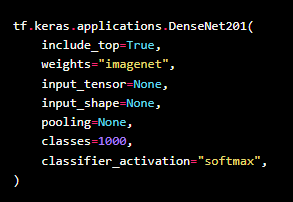

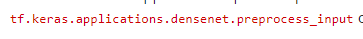

In [56]:
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions


# Sequential modeli oluşturun
DenseNet201_model = Sequential()


# --- Prerpossesing basladi---
# DenseNet201 modelinin giriş katmanını ekleyin
DenseNet201_model.add(keras.Input(shape=(224, 224, 3)))  # DenseNet201 için varsayılan giriş boyutu 224x224

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyin
DenseNet201_model.add(Lambda(densenet.preprocess_input))
# --- Prerpossesing bitti---


# Önceden eğitilmiş DenseNet201 modelini ekleyin
pretrained_model = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet', #'imagenet',
                                                     pooling='avg')
# DenseNet201'nin ağırlıklarını kullanalım
for layer in pretrained_model.layers:
    layer.trainable = False

DenseNet201_model.add(pretrained_model)

# Flatten Layer (Input)
DenseNet201_model.add(Flatten())

# Flatten yerine bunu da kullanabiliriz 
# MobileNetV2_model.add(GlobalAveragePooling2D())


# ---ANN---

# Fully Connected Layer
DenseNet201_model.add(Dense(512, activation='relu'))
DenseNet201_model.add(BatchNormalization())
DenseNet201_model.add(Dropout(0.3))

# Çıkış Katmanı
DenseNet201_model.add(Dense(4, activation='softmax'))


# Optimizer olarak özelleştirilmiş Adam optimizer kullanılır
optimizer = Adam(learning_rate=0.001) # Baslangic learning  rate degerimiz. LR asagida optimize edilecek. 

# Modeli derleyelim (compile edelim)
DenseNet201_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Callbacks tanımlanır
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Model özeti
DenseNet201_model.summary()

74836368/74836368 [==============================] - 36s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               983552    
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)              

### Train the Model 

In [57]:
DenseNet201_results = DenseNet201_model.fit(train_image_gen,
                    epochs=50,
                    validation_data = test_image_gen,
                    callbacks = [early_stop])

Epoch 1/50
105/105 [==============================] - 406s 4s/step - loss: 0.0653 - accuracy: 0.9809 - val_loss: 0.0223 - val_accuracy: 0.9964
Epoch 2/50
105/105 [==============================] - 393s 4s/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0239 - val_accuracy: 0.9917
Epoch 3/50
105/105 [==============================] - 392s 4s/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.0200 - val_accuracy: 0.9929
Epoch 4/50
105/105 [==============================] - 393s 4s/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0306 - val_accuracy: 0.9929
Epoch 5/50
105/105 [==============================] - 394s 4s/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0322 - val_accuracy: 0.9952
Epoch 6/50
105/105 [==============================] - 394s 4s/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0262 - val_accuracy: 0.9952
Epoch 7/50
105/105 [==============================] - 392s 4s/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0282 - val_accuracy: 0.9952

### Evaluating the Model

In [58]:
DenseNet201_summary = pd.DataFrame(DenseNet201_model.history.history)
DenseNet201_summary.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.002484,0.998808,0.022250,0.994055
15,0.003497,0.998808,0.026545,0.992866
16,0.004693,0.998808,0.025515,0.994055
17,0.001064,1.000000,0.024785,0.991677
18,0.000407,1.000000,0.024229,0.991677


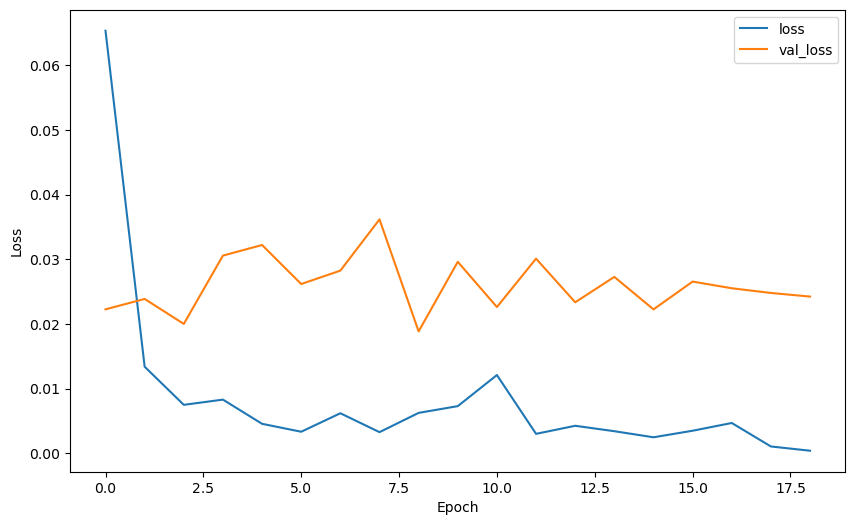

In [59]:
# Loss grafigi, 0'a yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(DenseNet201_summary.loss, label="loss")
plt.plot(DenseNet201_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

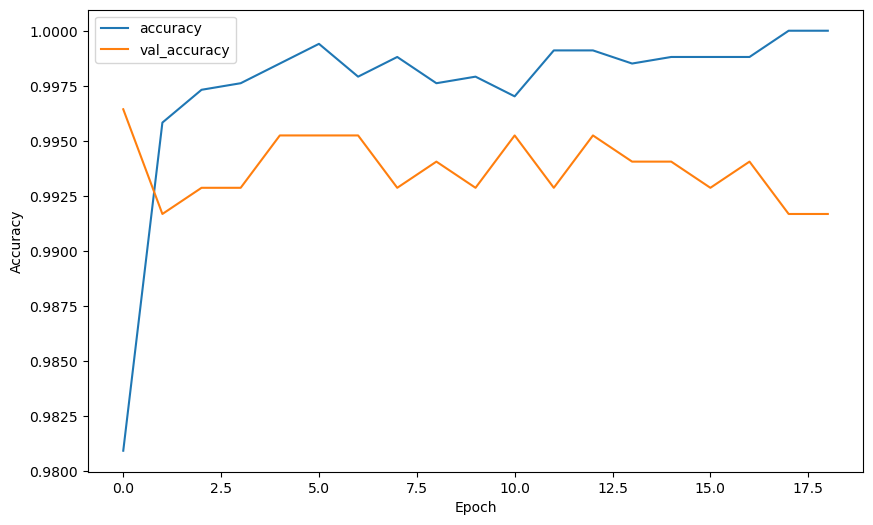

In [60]:
# Accuracy grafigi, 1'e yakin olmasi iyidir. 

plt.figure(figsize=(10,6))
plt.plot(DenseNet201_summary.accuracy, label="accuracy")
plt.plot(DenseNet201_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Evaluate the model

In [61]:
#Get Predictions;
DenseNet201_model_pred_probabilities = DenseNet201_model.predict(test_image_gen)
DenseNet201_model_pred_probabilities
# Transform Probabilites to Clasesses
DenseNet201_model_probs = np.array(DenseNet201_model_pred_probabilities)
DenseNet201_model_predictions = np.argmax(DenseNet201_model_probs, axis=1)
# Predictions
print("Predictions: ", DenseNet201_model_predictions[:50])
# Actual Values
print("Actual     : ", test_image_gen.classes[:50])
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, DenseNet201_model_predictions))
print(classification_report(test_image_gen.classes, DenseNet201_model_predictions))

27/27 [==============================] - 81s 3s/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[195   0   0   0]
 [  1 256   2   0]
 [  0   1 153   0]
 [  1   0   2 230]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       195
           1       1.00      0.99      0.99       259
           2       0.97      0.99      0.98       154
           3       1.00      0.99      0.99       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



### Save the Model

In [63]:
from tensorflow.keras.models import load_model
DenseNet201_model.save('DenseNet201.h5')

In [64]:
# With Keras
from tensorflow.keras.models import load_model
DenseNet201_model.save('DenseNet201.keras')

#  NasNetMobile

**Preprocessing yok, biz yapacagiz** https://keras.io/api/applications/nasnet/#nasnetmobile-function

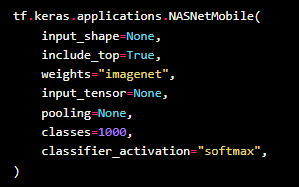

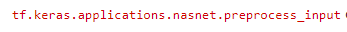

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import nasnet
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input, decode_predictions
from keras.optimizers import Adam



# Sequential modeli oluşturun
NASNetMobile_model = Sequential()

# --- Prerpossesing basladi---
# NASNetMobile modelinin giriş katmanını ekleyin
# NASNetMobile için varsayılan giriş boyutu 224x224
NASNetMobile_model.add(keras.Input(shape=(224, 224, 3)))

# preprocess_input fonksiyonunu Lambda katmanı ile ekleyin
NASNetMobile_model.add(Lambda(nasnet.preprocess_input))
# --- Prerpossesing bitti---


# Önceden eğitilmiş NASNetMobile modelini ekleyin
pretrained_model = tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3),
                                                      include_top=False,
                                                      weights='imagenet', #'imagenet',
                                                      pooling='avg')
# NASNetMobile'in ağırlıklarını kullanalım
for layer in pretrained_model.layers:
    layer.trainable = False


NASNetMobile_model.add(pretrained_model)

# Flatten Layer (Input)
NASNetMobile_model.add(Flatten())

# Flatten yerine bunu da kullanabiliriz 
# NASNetMobile_model.add(GlobalAveragePooling2D())


# ---ANN---

# Fully Connected Layer
NASNetMobile_model.add(Dense(512, activation='relu'))
NASNetMobile_model.add(BatchNormalization())
NASNetMobile_model.add(Dropout(0.3))

# Çıkış Katmanı
NASNetMobile_model.add(Dense(4, activation='softmax'))


# Optimizer olarak özelleştirilmiş Adam optimizer kullanılır
optimizer = Adam(learning_rate=0.001) # Baslangic learning  rate degerimiz. LR asagida optimize edilecek. 

# Modeli derleyelim (compile edelim)
NASNetMobile_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Callbacks tanımlanır
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Model özeti
NASNetMobile_model.summary()

19993432/19993432 [==============================] - 9s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 flatten_2 (Flatten)         (None, 1056)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               541184    
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               

### Train the Model

In [49]:
NASNetMobile_results = NASNetMobile_model.fit(train_image_gen,
                    epochs=30,
                    validation_data = test_image_gen,
                    callbacks = [early_stop])

Epoch 1/30
105/105 [==============================] - 140s 1s/step - loss: 0.0977 - accuracy: 0.9738 - val_loss: 0.0468 - val_accuracy: 0.9845
Epoch 2/30
105/105 [==============================] - 122s 1s/step - loss: 0.0246 - accuracy: 0.9937 - val_loss: 0.0549 - val_accuracy: 0.9881
Epoch 3/30
105/105 [==============================] - 122s 1s/step - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.0292 - val_accuracy: 0.9952
Epoch 4/30
105/105 [==============================] - 121s 1s/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0295 - val_accuracy: 0.9941
Epoch 5/30
105/105 [==============================] - 121s 1s/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 6/30
105/105 [==============================] - 122s 1s/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0264 - val_accuracy: 0.9917
Epoch 7/30
105/105 [==============================] - 121s 1s/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0216 - val_accuracy: 0.9941

### Evaluating the Model

In [50]:
NASNetMobile_summary = pd.DataFrame(NASNetMobile_model.history.history)
NASNetMobile_summary.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.009142,0.997019,0.020433,0.995244
21,0.009831,0.997317,0.020702,0.992866
22,0.004811,0.998510,0.019892,0.996433
23,0.004427,0.997914,0.019534,0.995244
24,0.004492,0.998510,0.019516,0.996433


In [51]:
#Get Predictions;
NASNetMobile_model_pred_probabilities = NASNetMobile_model.predict(test_image_gen)
NASNetMobile_model_pred_probabilities

# Transform Probabilites to Clasesses 
NASNetMobile_model_probs = np.array(NASNetMobile_model_pred_probabilities)
NASNetMobile_model_predictions = np.argmax(NASNetMobile_model_probs, axis=1)

# Predictions
print("Predictions: ", NASNetMobile_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

27/27 [==============================] - 25s 763ms/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [52]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, NASNetMobile_model_predictions))
print(classification_report(test_image_gen.classes, NASNetMobile_model_predictions))

[[195   0   0   0]
 [  0 258   1   0]
 [  0   0 153   1]
 [  0   0   1 232]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       154
           3       1.00      1.00      1.00       233

    accuracy                           1.00       841
   macro avg       1.00      1.00      1.00       841
weighted avg       1.00      1.00      1.00       841



### Save the Model

In [54]:
from tensorflow.keras.models import load_model
NASNetMobile_model.save('NASNetMobile.h5')

In [55]:
# With Keras
from tensorflow.keras.models import load_model
NASNetMobile_model.save('NASNetMobile.keras')

# EfficientNetV2S

Since **rescaling is embedded  in EfficientNetV2 group** (https://keras.io/api/applications/efficientnet_v2/#efficientnetv2s-function), **we mustn't scale our data before!!!**

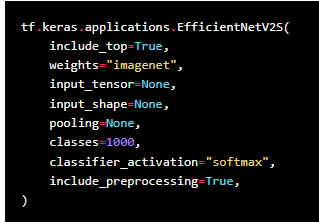

**EfficientNet2 grubunda kendi icinde scaling yaptigi icin verileri scaling yapmadan (255'e bolmeden) verecegiz modele.** 

**include_proprosessing = True** (defaulttu bu) oldugunda (gordugunde) disarda 255 e bolme verileri. 

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input


# EfficientNetV2B2 Modelini çağıralım
EfficientNetV2S_model = Sequential()

# Transfer Learning modelini tanimliyoruz. 
pretrained_model = EfficientNetV2S(include_top=False,
                                    input_shape=(224, 224, 3),
                                    weights='imagenet', # None ile denenebilir (uzun surebilir)
                                    pooling=None)



# InceptionV3'nin ağırlıklarını kullanalım
for layer in pretrained_model.layers:
    layer.trainable = False



EfficientNetV2S_model.add(pretrained_model)

# Flatten Layer (Input)
EfficientNetV2S_model.add(Flatten())

#----ANN----
# Fully Connected Layer
EfficientNetV2S_model.add(Dense(512, activation='relu'))
EfficientNetV2S_model.add(BatchNormalization())
EfficientNetV2S_model.add(Dropout(0.3))
                          

# Çıkış Katmanı
EfficientNetV2S_model.add(Dense(4, activation='softmax'))

# Optimizer olarak özelleştirilmiş Adam optimizer kullanılır
optimizer = Adam(learning_rate=0.001)  # Başlangıç learning rate değerimiz. LR aşağıda optimize edilecek.

# Modeli derleyelim
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])

# Callbacks tanımlanır
early_stop = EarlyStopping(monitor='val_loss', patience=10)


# LR'i optimize ediyoruz;
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
# Başlangıç LR ile başla, val_loss 3 adım boyunca düşmezse LR ile factor oranını çarparak LR'yi düşür
# ve yola yeni LR ile devam et. Bu işlemi LR min 0.0001 olana kadar devam ettir.

# Model özetini gösterelim
EfficientNetV2S_model.summary()   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               32113152  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                

### Model training

In [32]:
EfficientNetV2S_model_results = EfficientNetV2S_model.fit(train_image_gen,epochs=50,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/50
105/105 [==============================] - 335s 3s/step - loss: 0.1101 - accuracy: 0.9738 - val_loss: 0.0182 - val_accuracy: 0.9964
Epoch 2/50
105/105 [==============================] - 256s 2s/step - loss: 0.0209 - accuracy: 0.9943 - val_loss: 0.0210 - val_accuracy: 0.9941
Epoch 3/50
105/105 [==============================] - 262s 2s/step - loss: 0.0160 - accuracy: 0.9961 - val_loss: 0.0165 - val_accuracy: 0.9941
Epoch 4/50
105/105 [==============================] - 299s 3s/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0231 - val_accuracy: 0.9952
Epoch 5/50
105/105 [==============================] - 349s 3s/step - loss: 0.0098 - accuracy: 0.9964 - val_loss: 0.0159 - val_accuracy: 0.9976
Epoch 6/50
105/105 [==============================] - 263s 3s/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0157 - val_accuracy: 0.9964
Epoch 7/50
105/105 [==============================] - 265s 3s/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0140 - val_accuracy: 0.9988

### Evaluating the Model

In [33]:
EfficientNetV2S_summary = pd.DataFrame(EfficientNetV2S_model.history.history)
EfficientNetV2S_summary.tail()

,loss,accuracy,val_loss,val_accuracy
12,0.004573,0.997914,0.016787,0.995244
13,0.004442,0.998212,0.027257,0.995244
14,0.002699,0.999106,0.025666,0.995244
15,0.003119,0.998808,0.026967,0.995244
16,0.005110,0.999106,0.090098,0.991677


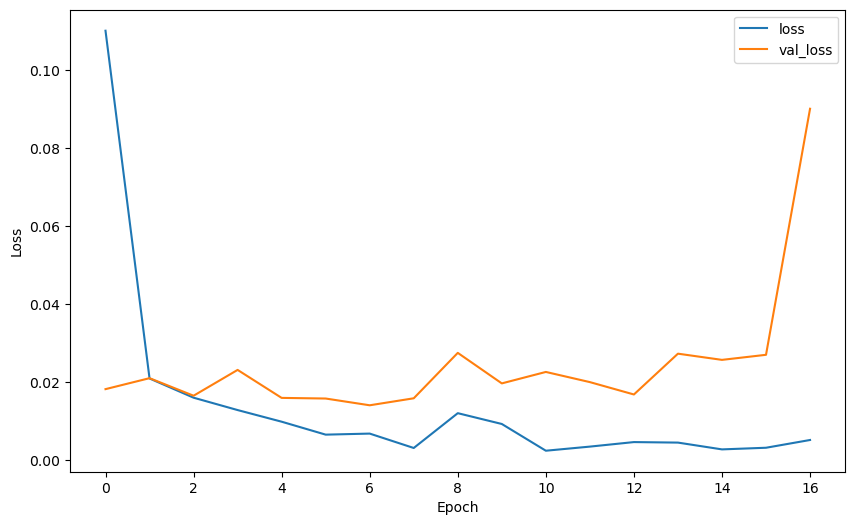

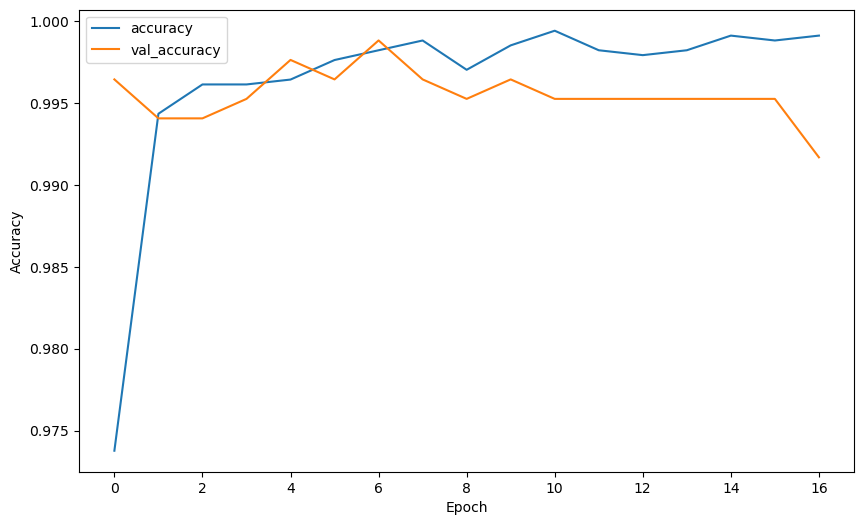

In [34]:
# Loss Figure
plt.figure(figsize=(10,6))
plt.plot(EfficientNetV2S_summary.loss, label="loss")
plt.plot(EfficientNetV2S_summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

#Accuracy Figure
plt.figure(figsize=(10,6))
plt.plot(EfficientNetV2S_summary.accuracy, label="accuracy")
plt.plot(EfficientNetV2S_summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [35]:
#Get Predictions;
EfficientNetV2S_model_pred_probabilities = EfficientNetV2S_model.predict(test_image_gen)
EfficientNetV2S_model_pred_probabilities
# Transform Probabilites to Clasesses
EfficientNetV2S_model_probs = np.array(EfficientNetV2S_model_pred_probabilities)
EfficientNetV2S_model_predictions = np.argmax(EfficientNetV2S_model_probs, axis=1)
# Predictions
print("Predictions: ", EfficientNetV2S_model_predictions[:50])
# Actual Values
print("Actual     : ", test_image_gen.classes[:50])
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, EfficientNetV2S_model_predictions))
print(classification_report(test_image_gen.classes, EfficientNetV2S_model_predictions))

27/27 [==============================] - 50s 2s/step
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual     :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[193   0   0   2]
 [  0 258   1   0]
 [  2   0 152   0]
 [  2   0   0 231]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       195
           1       1.00      1.00      1.00       259
           2       0.99      0.99      0.99       154
           3       0.99      0.99      0.99       233

    accuracy                           0.99       841
   macro avg       0.99      0.99      0.99       841
weighted avg       0.99      0.99      0.99       841



### Save the Model

In [40]:
from tensorflow.keras.models import load_model
EfficientNetV2S_model.save('EfficientNetV2S.h5')

In [41]:
from tensorflow.keras.models import load_model
EfficientNetV2S_model.save('EfficientNetV2S.keras')

# ConvNeXtTiny
**Preprocessing  var, biz yapmayacagiz!!!!**  https://keras.io/api/applications/convnext/#convnexttiny-function

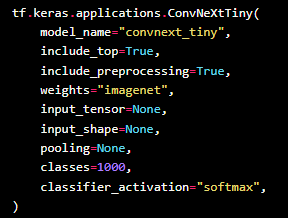


In [ ]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# ConvNeXtTiny modelini yükleyin
convnext_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

# Transfer learning modelini oluşturun
transfer_model = Sequential()

# ConvNeXtTiny'nin ağırlıklarını kullanalım
for layer in convnext_model.layers:
    layer.trainable = False # Agirliklari degistirme 

# ConvNeXtTiny modelini ekleyin
transfer_model.add(convnext_model)

# Flatten Layer (Input)
transfer_model.add(Flatten())

# Fully Connected Layer
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.3))

# Çıkış Katmanı
transfer_model.add(Dense(4, activation='softmax'))

# Modeli derleyin
optimizer = Adam(learning_rate=0.001)
transfer_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

transfer_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

### Model Training

In [70]:
# Modeli eğitelim
ConvNeXtTiny_model_results = transfer_model.fit(train_image_gen, epochs=50,
                                                  validation_data=test_image_gen,
                                                  callbacks=[early_stop]) 

Epoch 1/50
105/105 [==============================] - 1319s 13s/step - loss: 5.8858e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9941
Epoch 2/50
105/105 [==============================] - 1307s 12s/step - loss: 0.0027 - accuracy: 0.9982 - val_loss: 0.0440 - val_accuracy: 0.9941
Epoch 3/50
105/105 [==============================] - 1312s 13s/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.0365 - val_accuracy: 0.9952
Epoch 4/50
105/105 [==============================] - 1325s 13s/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0320 - val_accuracy: 0.9941
Epoch 5/50
105/105 [==============================] - 1325s 13s/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 0.0359 - val_accuracy: 0.9929
Epoch 6/50
105/105 [==============================] - 1322s 13s/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0229 - val_accuracy: 0.9941
Epoch 7/50
105/105 [==============================] - 1316s 13s/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0201 - va

### Evaulating the Model

In [71]:
ConvNeXtTiny_summary = pd.DataFrame(ConvNeXtTiny_model.history.history)
ConvNeXtTiny_summary.tail()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
#Get Predictions;
ConvNeXtTiny_model_pred_probabilities = ConvNeXtTiny_model.predict(test_image_gen)
ConvNeXtTiny_model_pred_probabilities

# Transform Probabilites to Clasesses 
ConvNeXtTiny_model_probs = np.array(ConvNeXtTiny_model_pred_probabilities)
ConvNeXtTiny_model_predictions = np.argmax(ConvNeXtTiny_model_probs, axis=1)

# Predictions
print("Predictions: ", ConvNeXtTiny_model_predictions[:50])

# Actual Values
print("Actual     : ", test_image_gen.classes[:50])

In [ ]:
# Eval metrics
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_image_gen.classes, ConvNeXtTiny_model_predictions))
print(classification_report(test_image_gen.classes, ConvNeXtTiny_model_predictions))

### Save the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save('ConvNeXtTiny.h5')

In [ ]:
from tensorflow.keras.models import load_model
model.save('ConvNeXtTiny.keras')

# Compare the Model Performances

In [ ]:
test_results = [
    {'Test': 'Manuel CNN', 'Accuracy Score': 0.98, 'Val_Accuracy': 0.91},
    {'Test': 'Xception', 'Accuracy Score': 0.79, 'Val_Accuracy': 0.67},
    #{'Test': 'VGG16', 'Accuracy Score': 0.98, 'Val_Accuracy': 0.88},
    {'Test': 'ResNet152', 'Accuracy Score': 0.99, 'Val_Accuracy': 0.99},
    {'Test': 'InceptionV3', 'Accuracy Score': 0.99, 'Val_Accuracy': 0.98},
    {'Test': 'MobileNet', 'Accuracy Score': 0.99, 'Val_Accuracy': 0.98},
    {'T#est': 'DenseNet', 'Accuracy Score': 0.90, 'Val_Accuracy': 0.85},
    {'Test': 'NasNetMobile', 'Accuracy Score': 0.75, 'Val_Accuracy': 0.53},
    {'Test': 'EfficientNetV2S', 'Accuracy Score': 0.99, 'Val_Accuracy': 0.99},
    #{'Test': 'ConvNeXtTiny', 'Accuracy Score': 1, 'Val_Accuracy': 0.95}]

In [ ]:
# Transform to DataFrame 
results_df = pd.DataFrame(test_results)

# Sort by f1-score and Misclassification together; 
sorted_results = results_df.sort_values(by=['Accuracy Score', 'Val_Accuracy'], ascending=[False, False])

# Let's show the results by resetting the indexes
sorted_results_reset = sorted_results.reset_index(drop=True)

# Show the results;   
print(sorted_results_reset) 

**YORUM:** En basarili model ConNeXtTiny modeli olmustur. Genel olarak transfer learning modellerinin manuel CNN'den  daha iyi performans gosterdikleri belirlenmistir. 

#  PREDICTION

En iyi skoru ConvNextTiny modelinde aldigimiz icin bu modeli kullanarak final predictionlari elde edecegiz.

In [3]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Modeli yükleyin---> DenseNetv2
model = tf.keras.models.load_model('DenseNet201.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\new_img\kupa2.png")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 16s 16s/step
Tahmin edilen sınıf: 0


In [21]:
train_image_gen.class_indices

{'Area Rugs': 0, 'Coffee Cups & Mugs': 1, 'Paints': 2, 'Yarn': 3}

In [22]:
test_image_gen.class_indices

{'Area Rugs': 0, 'Coffee Cups & Mugs': 1, 'Paints': 2, 'Yarn': 3}

In [47]:
# Modeli yükleyin  ---> InsceptionV3  sampiyon !!!!!!!!!!!!!
model = tf.keras.models.load_model('InceptionV3.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\kupa4.png")
image = image.resize((299, 299))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 2s 2s/step
Tahmin edilen sınıf: 1


In [38]:
# Modeli yükleyin  ---> Xception
model = tf.keras.models.load_model('Xception.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 6s 6s/step
Tahmin edilen sınıf: 0


In [45]:
# Modeli yükleyin  ---> Manuel_CNN
model = tf.keras.models.load_model('Manuel_CNN.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\kupa3.png")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 0s 218ms/step
Tahmin edilen sınıf: 1


In [ ]:
# Modeli yükleyin  ---> VGG16
model = tf.keras.models.load_model('VGG16.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

In [12]:
# Modeli yükleyin  ---> ResNet152
model = tf.keras.models.load_model('ResNet152.keras', compile=False, custom_objects={'<lambda>': lambda x: x}, safe_mode=False)

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\Seher\OneDrive\Masaüstü\DL Streamlit\kupa3.png")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 3s 3s/step
Tahmin edilen sınıf: 1


In [ ]:
# Modeli yükleyin  ---> MobilNet
model = tf.keras.models.load_model('MobilNet.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

In [ ]:
# Modeli yükleyin  ---> NASNetMobile
model = tf.keras.models.load_model('NASNetMobile.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

In [ ]:
# Modeli yükleyin  ---> EfficientNetV2S
model = tf.keras.models.load_model('EfficientNetV2S.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

In [ ]:
# Modeli yükleyin  ---> ConvNeXtTiny
model = tf.keras.models.load_model('ConvNeXtTiny.h5')

# Yeni görüntüyü açın ve uygun bir formata dönüştürün
image = Image.open(r"C:\Users\ypb23112\OneDrive - University of Strathclyde\Desktop\DL 1\Model_Final\Model_1\new_img\hali.jpg")
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB'))
image_array = np.expand_dims(image_array, axis=0)

# Tahmin yapın
prediction = model.predict(image_array)

# Tahmin edilen sınıfı ekrana yazdırın
predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

# DEPLOYMENT ON THE STREAMLIT

Bu calismanin kisa versiyonunun Streamlit ile deploy edilmis hali: https://flowers-data-cnn-and-transfer-learning-models-project.streamlit.app/


# CONCLUSSUION

Bu calismada:

 1) Train datasina image augmented (boyut vb. değişiklikle çoğaltma) yaptik ama test datasina yapmadik.
 
 2) Scailng islemini modellerin disinda yapmadik, cunku bazi transfer learning modelleri kendi icinde bir daha scaling yapiyor. 
 
 3) Once manuel model kurduk daha sonra transfer learning modellerini kullanarak sonuçları karşılaştırdık. 
 
 4) Modeller eğitildikten sonra karşılaştırılıp en hızlı ve en güvenilir olan modeller streamlite aktarıldı.